In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install venn

  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19701 sha256=0fced633c1265681f019f913fee586781a62bd5b1a8d58a67a87ea1e779d3223
  Stored in directory: /root/.cache/pip/wheels/b8/2a/b1/a1ff9ba87eb919daed348de8c17b00024dfef34b35e7002e6c
Successfully built venn


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from venn import venn
import matplotlib.ticker as ticker
from scipy import stats
from scipy.interpolate import UnivariateSpline


drugnames  = "Fluoxetine"
# the AED_ID count you printed
AED_ID = pd.read_csv("/content/drive/MyDrive/RP_A/REPORT/RAW_DATA/AED_ID.txt")
all_reports = len(AED_ID)

base_path   = f"/content/drive/MyDrive/RP_A/REPORT/"
os.makedirs(f"{base_path}/VISUALIZATIONS", exist_ok=True)


# Global style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.dpi': 300,
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'axes.spines.right': False,
    'axes.spines.top': False})

# **[1001] SOC - Disproportionality Signal Forest Plot**

<ipython-input-22-2d4140d590a8>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)


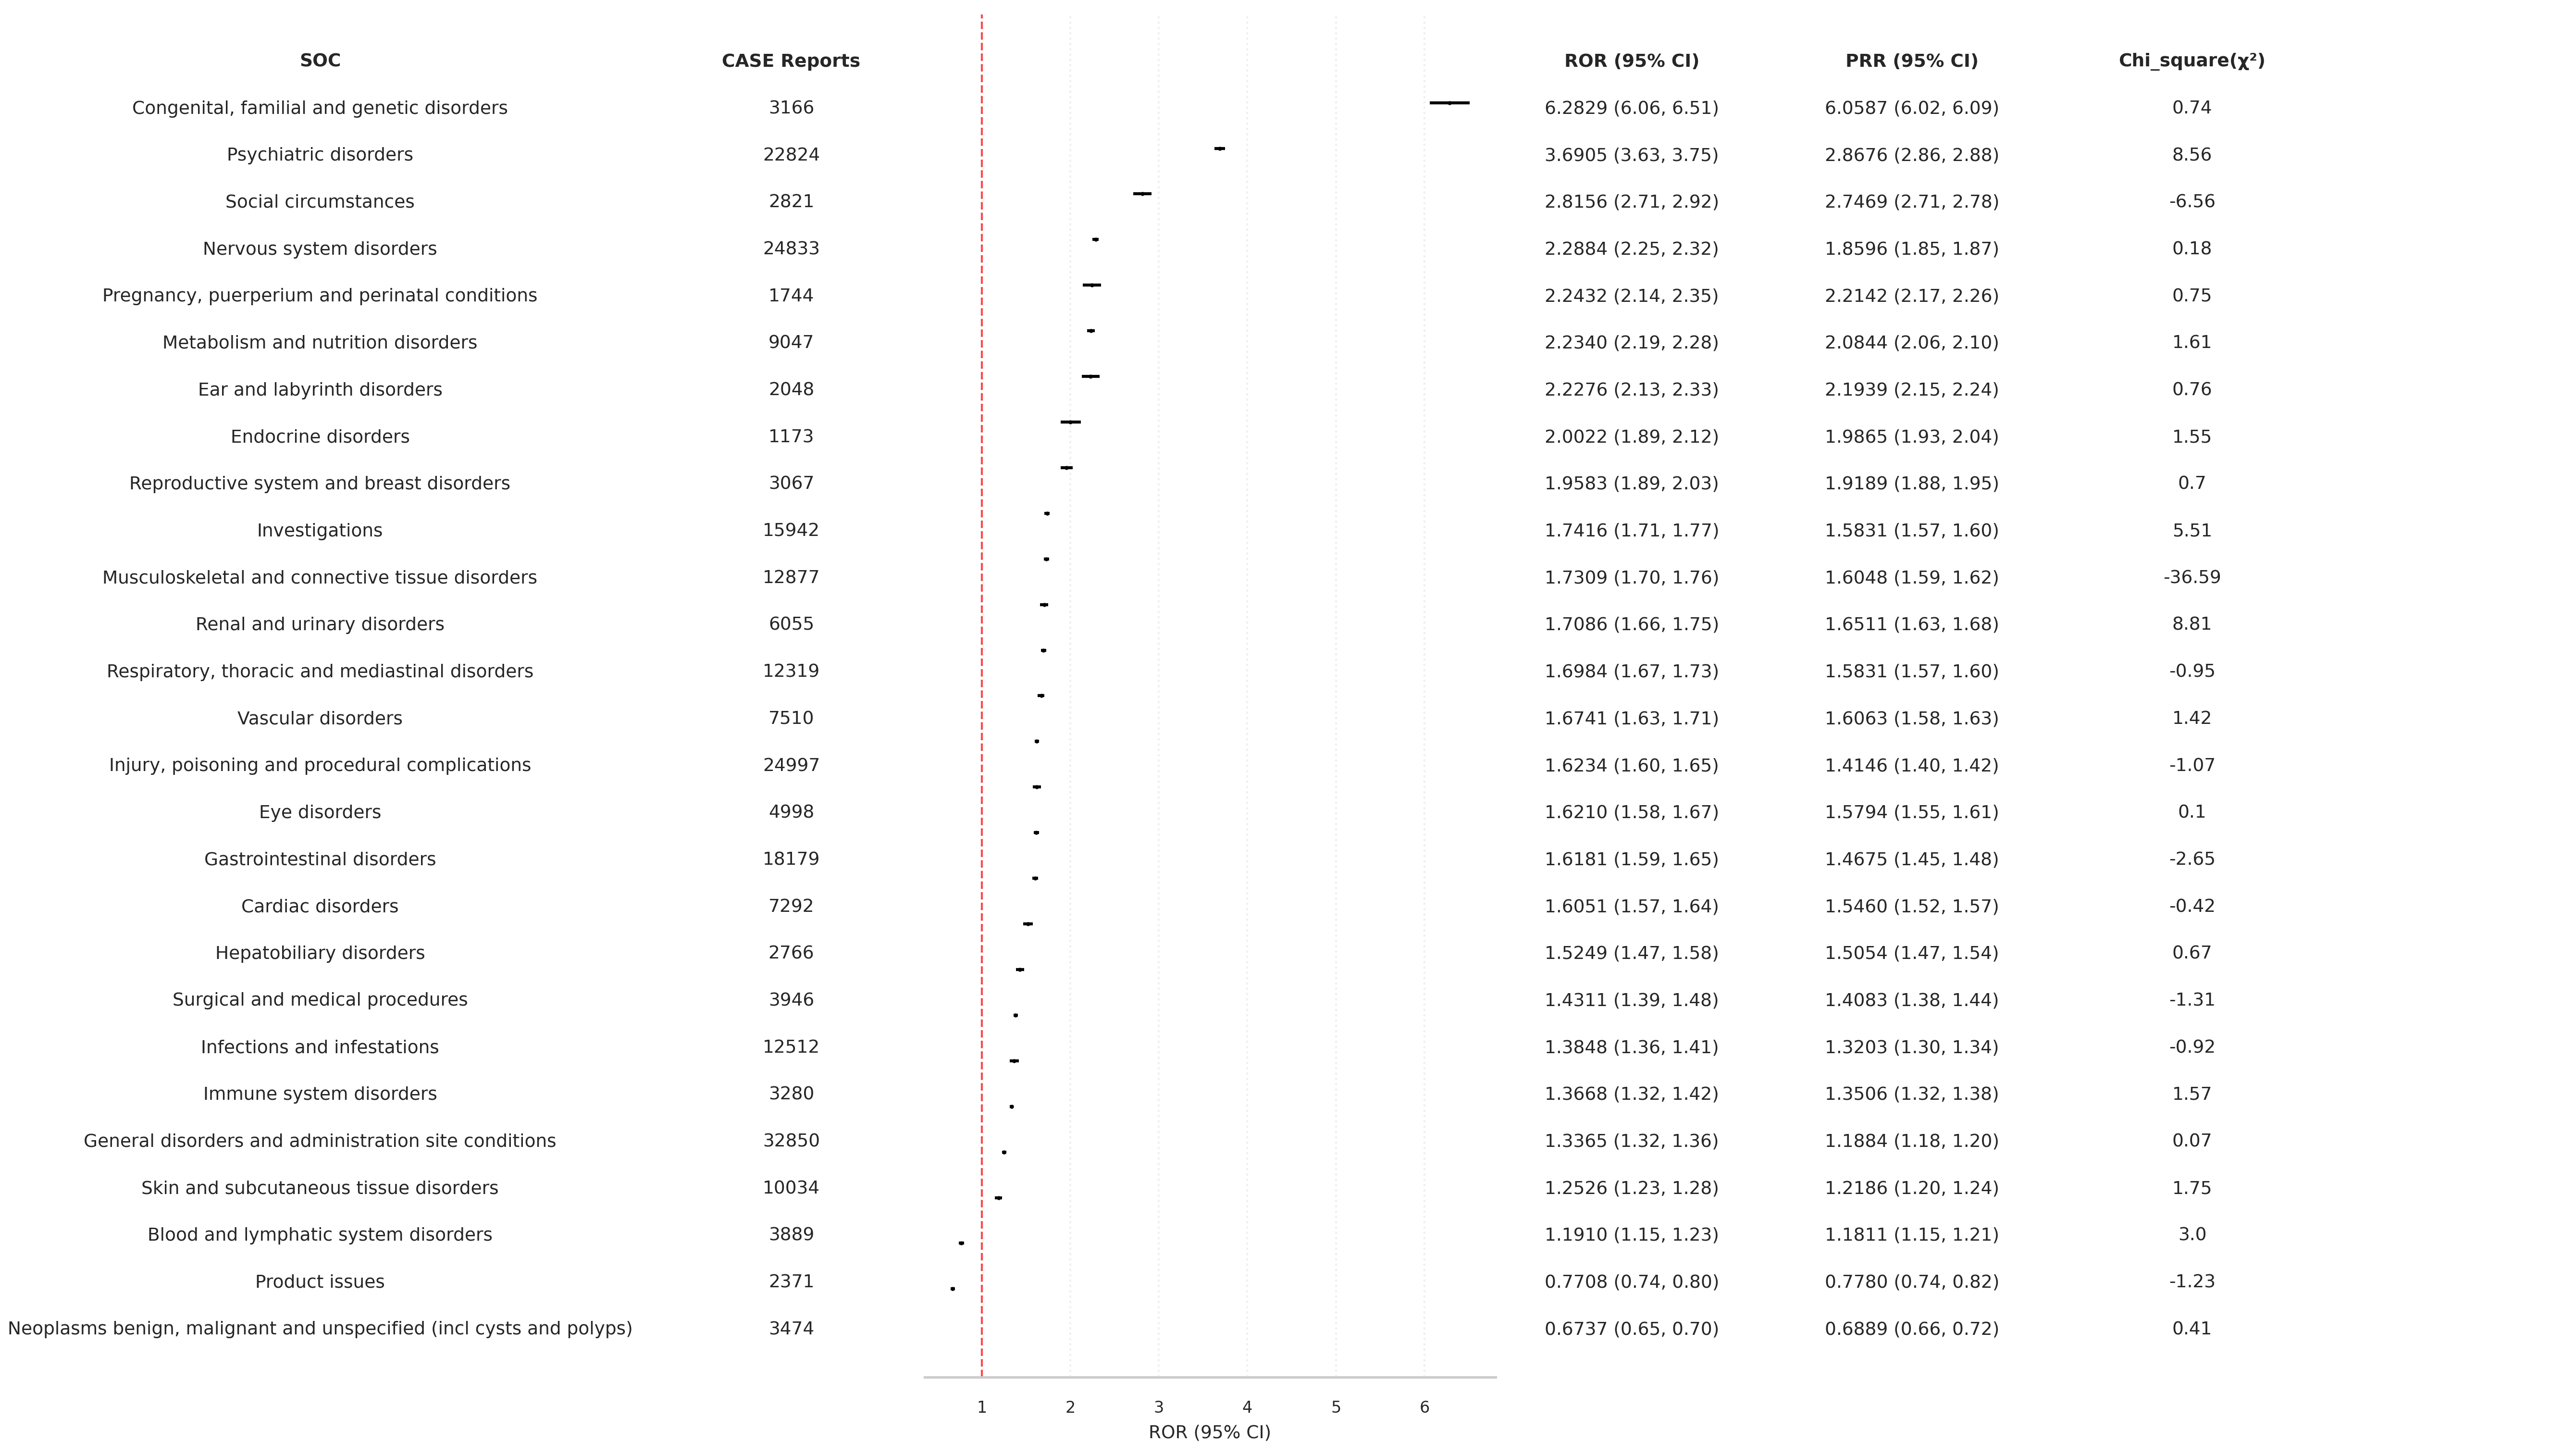

In [22]:
def plot_signal_forest(data_path, output_path):
    # load
    if data_path.endswith('.csv'):
        df = pd.read_csv(data_path)
    else:
        df = pd.read_excel(data_path)

    # extract numeric ROR/PRR from the leading number in the CI string
    df['ror'] = df['ROR (95% CI)'].str.extract(r'^([\d\.]+)').astype(float)
    df['prr'] = df['PRR (95% CI)'].str.extract(r'^([\d\.]+)').astype(float)

    df['ror_formatted'] = (
        df['ROR (95% CI)']
          .str.replace(r'\[', '(', regex=True)
          .str.replace(r'\]', ')', regex=True))
    df['prr_formatted'] = (
        df['PRR (95% CI)']
          .str.replace(r'\[', '(', regex=True)
          .str.replace(r'\]', ')', regex=True))

    # sort
    df = df.sort_values('ror', ascending=False)
    n = len(df)
    cell_h = 1/(n+2)
    rows = 1 - (np.arange(n)*cell_h + cell_h*1.5)

    left = df[['SOC']].values
    mid  = df[['CASE Reports']].values
    right= np.column_stack([df['ror_formatted'], df['prr_formatted'], df['Chi_square(χ²)']])


    fig, ax = plt.subplots(figsize=(18, max(4, n*0.35)))
    soc_w, rep_w, forest_w = 0.20, 0.11, 0.22
    ror_w, prr_w, chi_w    = 0.13, 0.13, 0.07
    x0 = 0.05

    # left table: SOC
    t1 = ax.table(cellText=left, colLabels=['SOC'],
                  bbox=[x0-0.03, 0, soc_w, 1], cellLoc='center', edges='')
    # middle table: CASE Reports
    t2 = ax.table(cellText=mid,  colLabels=['CASE Reports'],
                  bbox=[x0+soc_w, 0, rep_w, 1], cellLoc='center', edges='')
    # right table: formatted ROR/PRR/Chi²
    t3 = ax.table(cellText=right,
                  colLabels=['ROR (95% CI)', 'PRR (95% CI)', 'Chi_square(χ²)'],
                  bbox=[x0+soc_w+rep_w+forest_w, 0, ror_w+prr_w+chi_w, 1],
                  cellLoc='center', edges='')

    for tbl in (t1, t2, t3):
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(9)
        for (i, j), cell in tbl.get_celld().items():
            cell.set_height(cell_h)
            if i == 0:
                cell.set_text_props(weight='bold')
            cell.set_edgecolor('none')

    left_forest = x0 + soc_w + rep_w
    ax_f = fig.add_axes([left_forest, 0, forest_w, 1])
    ax_f.errorbar(
        df['ror'], rows,
        xerr=[df['ror'] - df['ror_lower_bound'],
              df['ror_upper_bound'] - df['ror']],
        fmt='o', color='black', capsize=3, markersize=2
    )
    ax_f.axvline(1, ls='--', color='red', lw=1, alpha=0.7)
    ax_f.set_ylim(-0.015, 1.015)
    for spine in ('top','right','left'):
        ax_f.spines[spine].set_visible(False)
    ax_f.set_yticks([])
    ax_f.set_xlabel('ROR (95% CI)', fontsize=9)
    ax_f.grid(axis='x', ls=':', alpha=0.3)
    ax_f.tick_params(labelsize=8)
    ax_f.set_facecolor('none')
    ax.tick_params(axis='y', pad=50)

    ax.axis('off')
    plt.tight_layout(pad=1)
    plt.savefig(output_path, bbox_inches='tight', dpi=300)

plot_signal_forest(f"{base_path}/MINING_REPORT/signal_tmp_soc.xlsx",
                   f"{base_path}/VISUALIZATIONS/[1001]SOC - SIGNAL_FOREST.png")


# **[1002] PT - TOP20 Adverse Event Frequence**

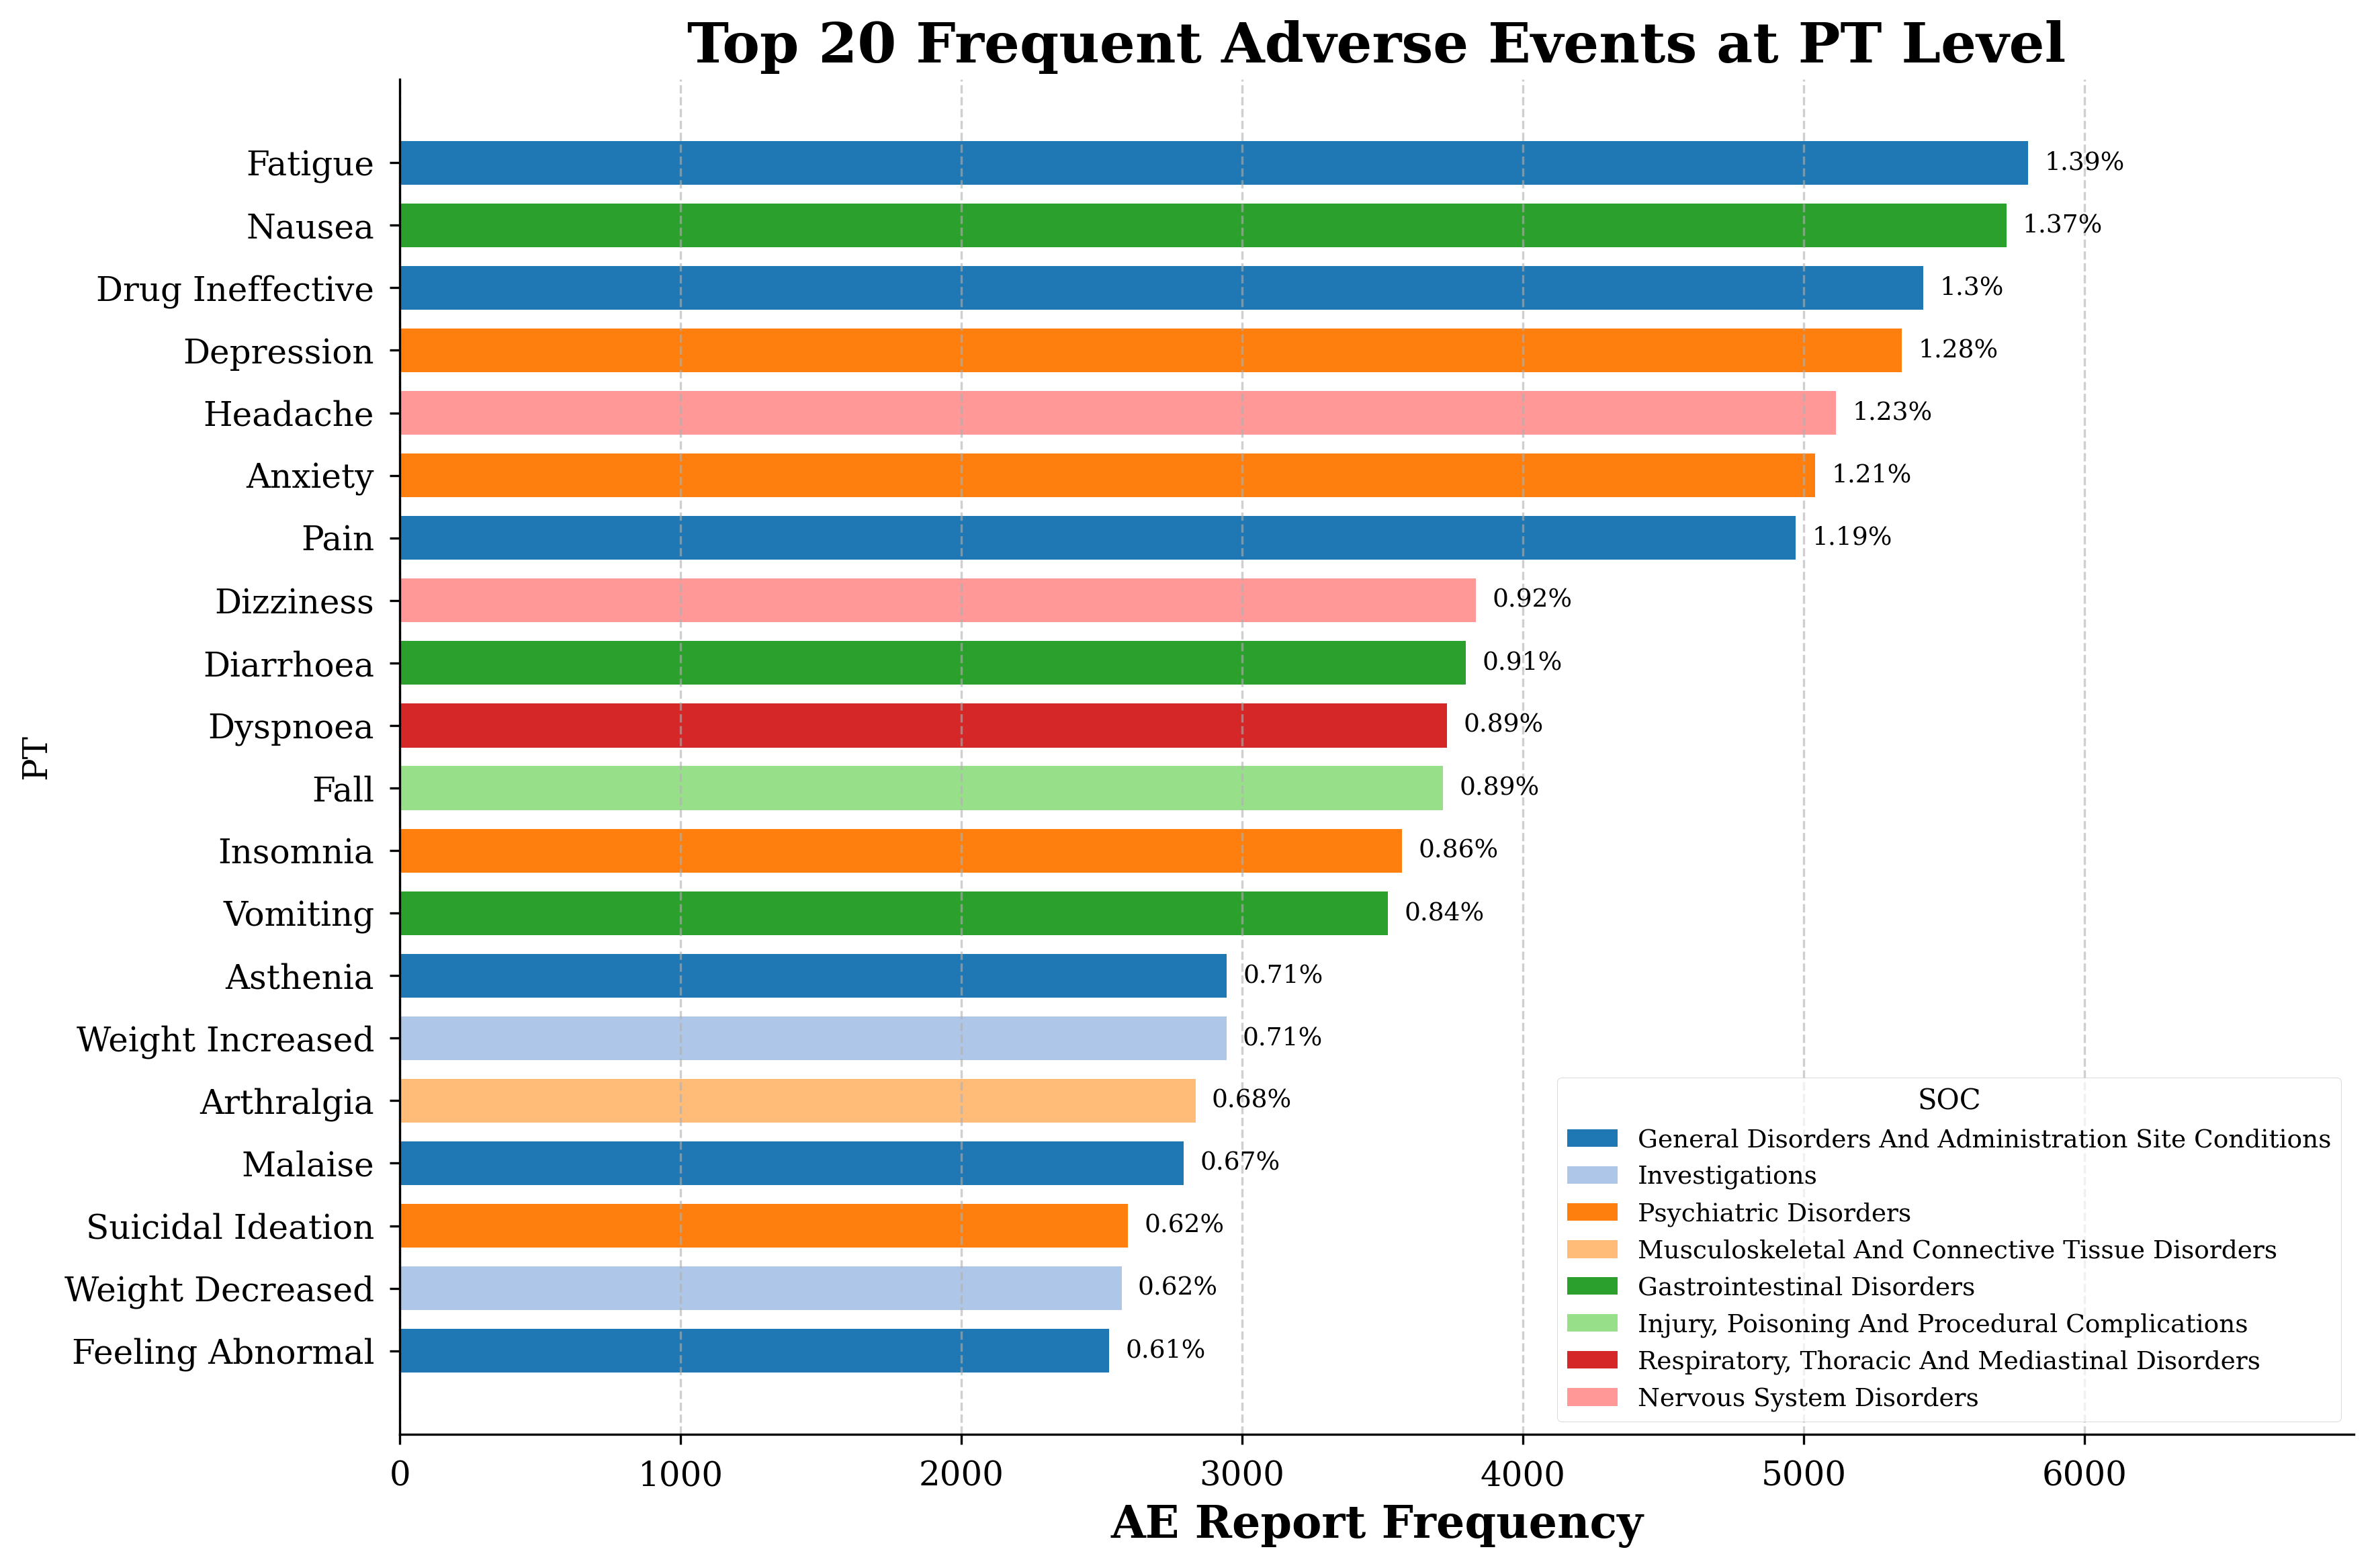

In [5]:
def plot_top20_ae(data_path, output_path):
    signal_sorted_num = pd.read_excel(data_path)
    a = signal_sorted_num.a.sum()

    top_20 = signal_sorted_num.sort_values('a', ascending=False).head(20).copy()

    top_20['PT'] = top_20['PT'].str.title()

    top_20['SOC'] = top_20['SOC'].str.title()
    top_20 = top_20.sort_values('a', ascending=True)

    top_20['percentage'] = (top_20['a'] / a * 100).round(2)

    unique_soc = top_20['SOC'].unique()
    color_map = {soc: plt.cm.tab20(i) for i, soc in enumerate(unique_soc)}

    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        top_20['PT'],
        top_20['a'],
        color=[color_map[soc] for soc in top_20['SOC']],
        height=0.7
    )

    for bar, percentage in zip(bars, top_20['percentage']):
        width = bar.get_width()
        plt.text(
            width + max(top_20['a'])*0.01,
            bar.get_y() + bar.get_height()/2,
            f'{percentage}%',
            va='center',
            ha='left',
            fontsize=9)

    plt.xlabel('AE Report Frequency', fontsize=16, fontweight='bold')
    plt.ylabel('PT', fontsize=12)
    plt.title('Top 20 Frequent Adverse Events at PT Level', fontsize=20, fontweight='bold')

    legend_elements = [Patch(facecolor=color_map[soc], label=soc) for soc in unique_soc]
    plt.legend(
        handles=legend_elements,
        title='SOC',
        title_fontsize='10',
        fontsize='9',
        loc='lower right',
        framealpha=0.7)

    plt.xlim(right=max(top_20['a']) * 1.2)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_top20_ae(f"{base_path}/MINING_REPORT/signal_pt&soc.xlsx",
              f"{base_path}/VISUALIZATIONS/[1002]PT - TOP20_AE.png")

# **[1003] PT - TOP15 Adverse Event Forest Plot - BCPNN**

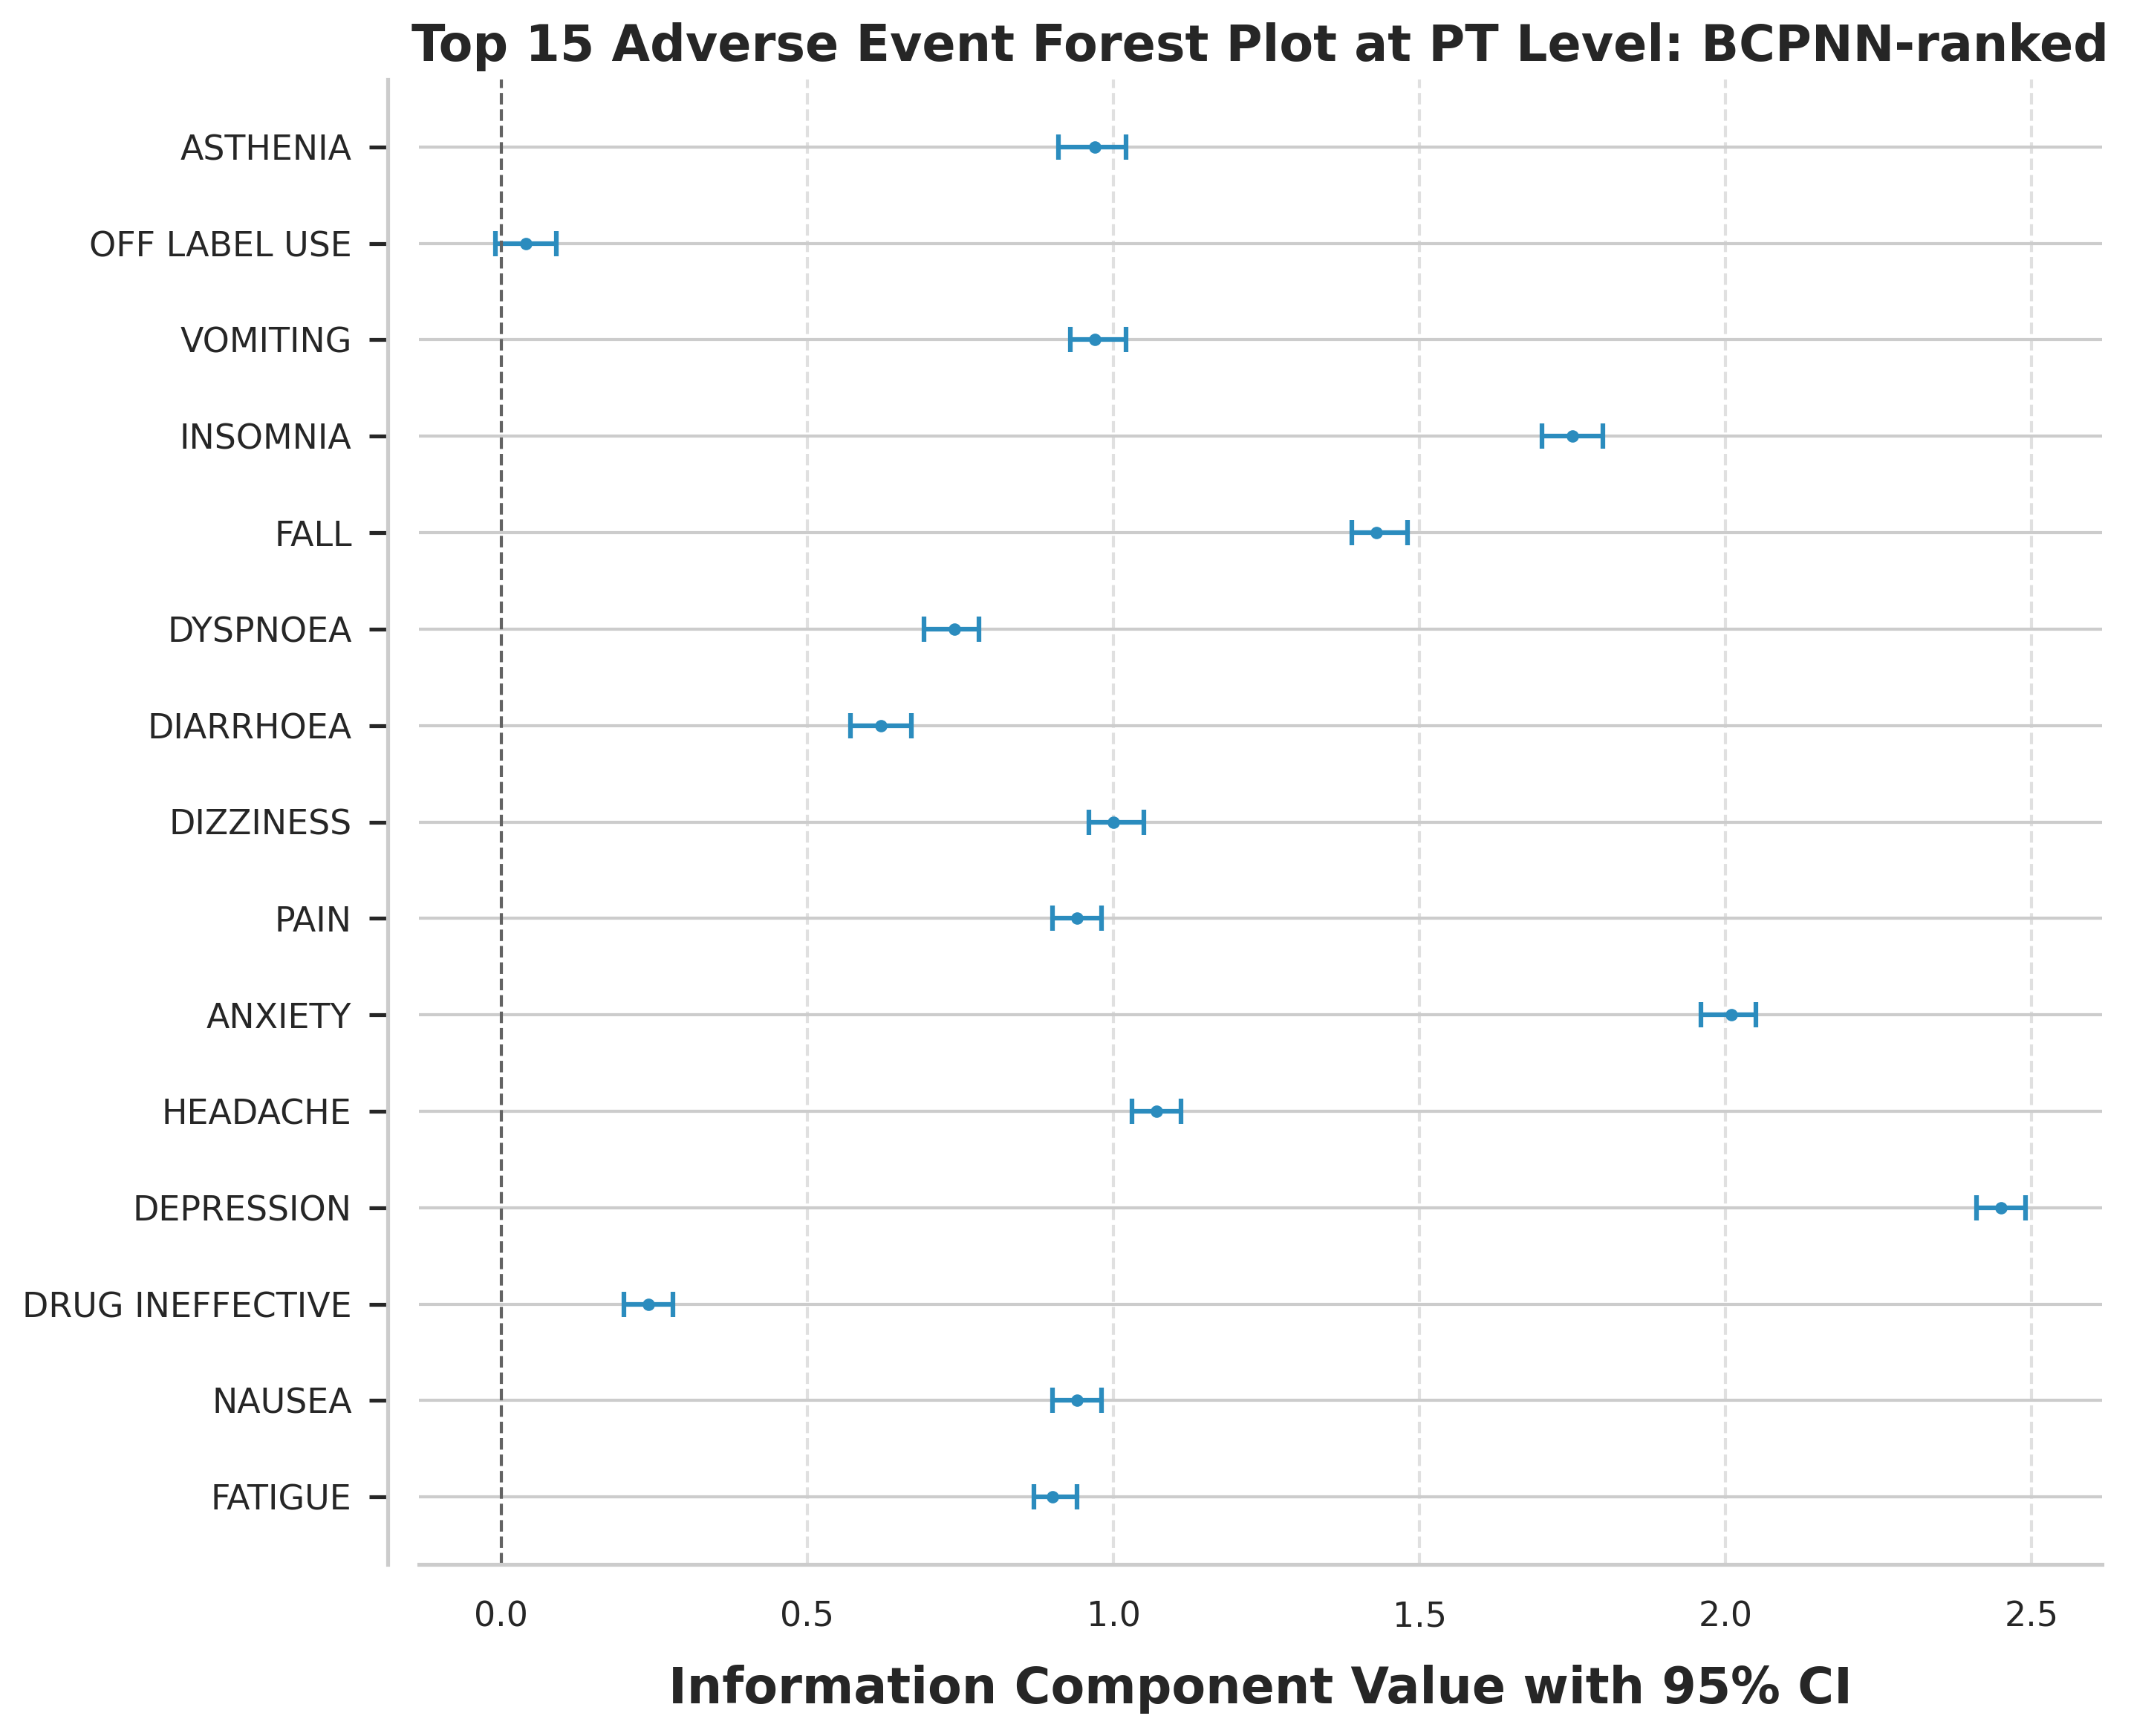

In [21]:
def plot_ae_forest(data_path, output_path):
    df = pd.read_excel(data_path)
    sorted_df = df.sort_values(by='a', ascending=False).head(15)
    sorted_df = sorted_df.set_index('PT')

    plt.figure(figsize=(10, 8), dpi=300)
    ax = plt.subplot(111)

    y_pos = range(len(sorted_df))
    ax.errorbar(sorted_df['BCPNN(IC)'], y_pos,
                xerr=[sorted_df['BCPNN(IC)'] - sorted_df['bcpnn_lower_bound'],
                    sorted_df['bcpnn_upper_bound'] - sorted_df['BCPNN(IC)']],
                fmt='o', color='#2b8cbe', markersize=4,
                elinewidth=1.5, capsize=4, capthick=1.5)

    ax.axvline(x=0, color='#636363', linestyle='--', linewidth=1)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df.index.tolist(), fontsize=10)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    ax.set_xlabel('Information Component Value with 95% CI', fontsize=16,fontweight='bold', labelpad=10)
    ax.xaxis.grid(True, linestyle='--', alpha=0.6)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    plt.tight_layout(pad=2)
    plt.title('Top 15 Adverse Event Forest Plot at PT Level: BCPNN-ranked', fontsize=16, fontweight='bold')
    plt.savefig(output_path)
    plt.show()

plot_ae_forest(f"{base_path}/MINING_REPORT/signal_tmp_pt.xlsx",
               f"{base_path}/VISUALIZATIONS/[1003]PT - BCPNN_TOP15_AE.png")

# **[1004] PT - Venn Diagram**

<Figure size 3000x3000 with 0 Axes>

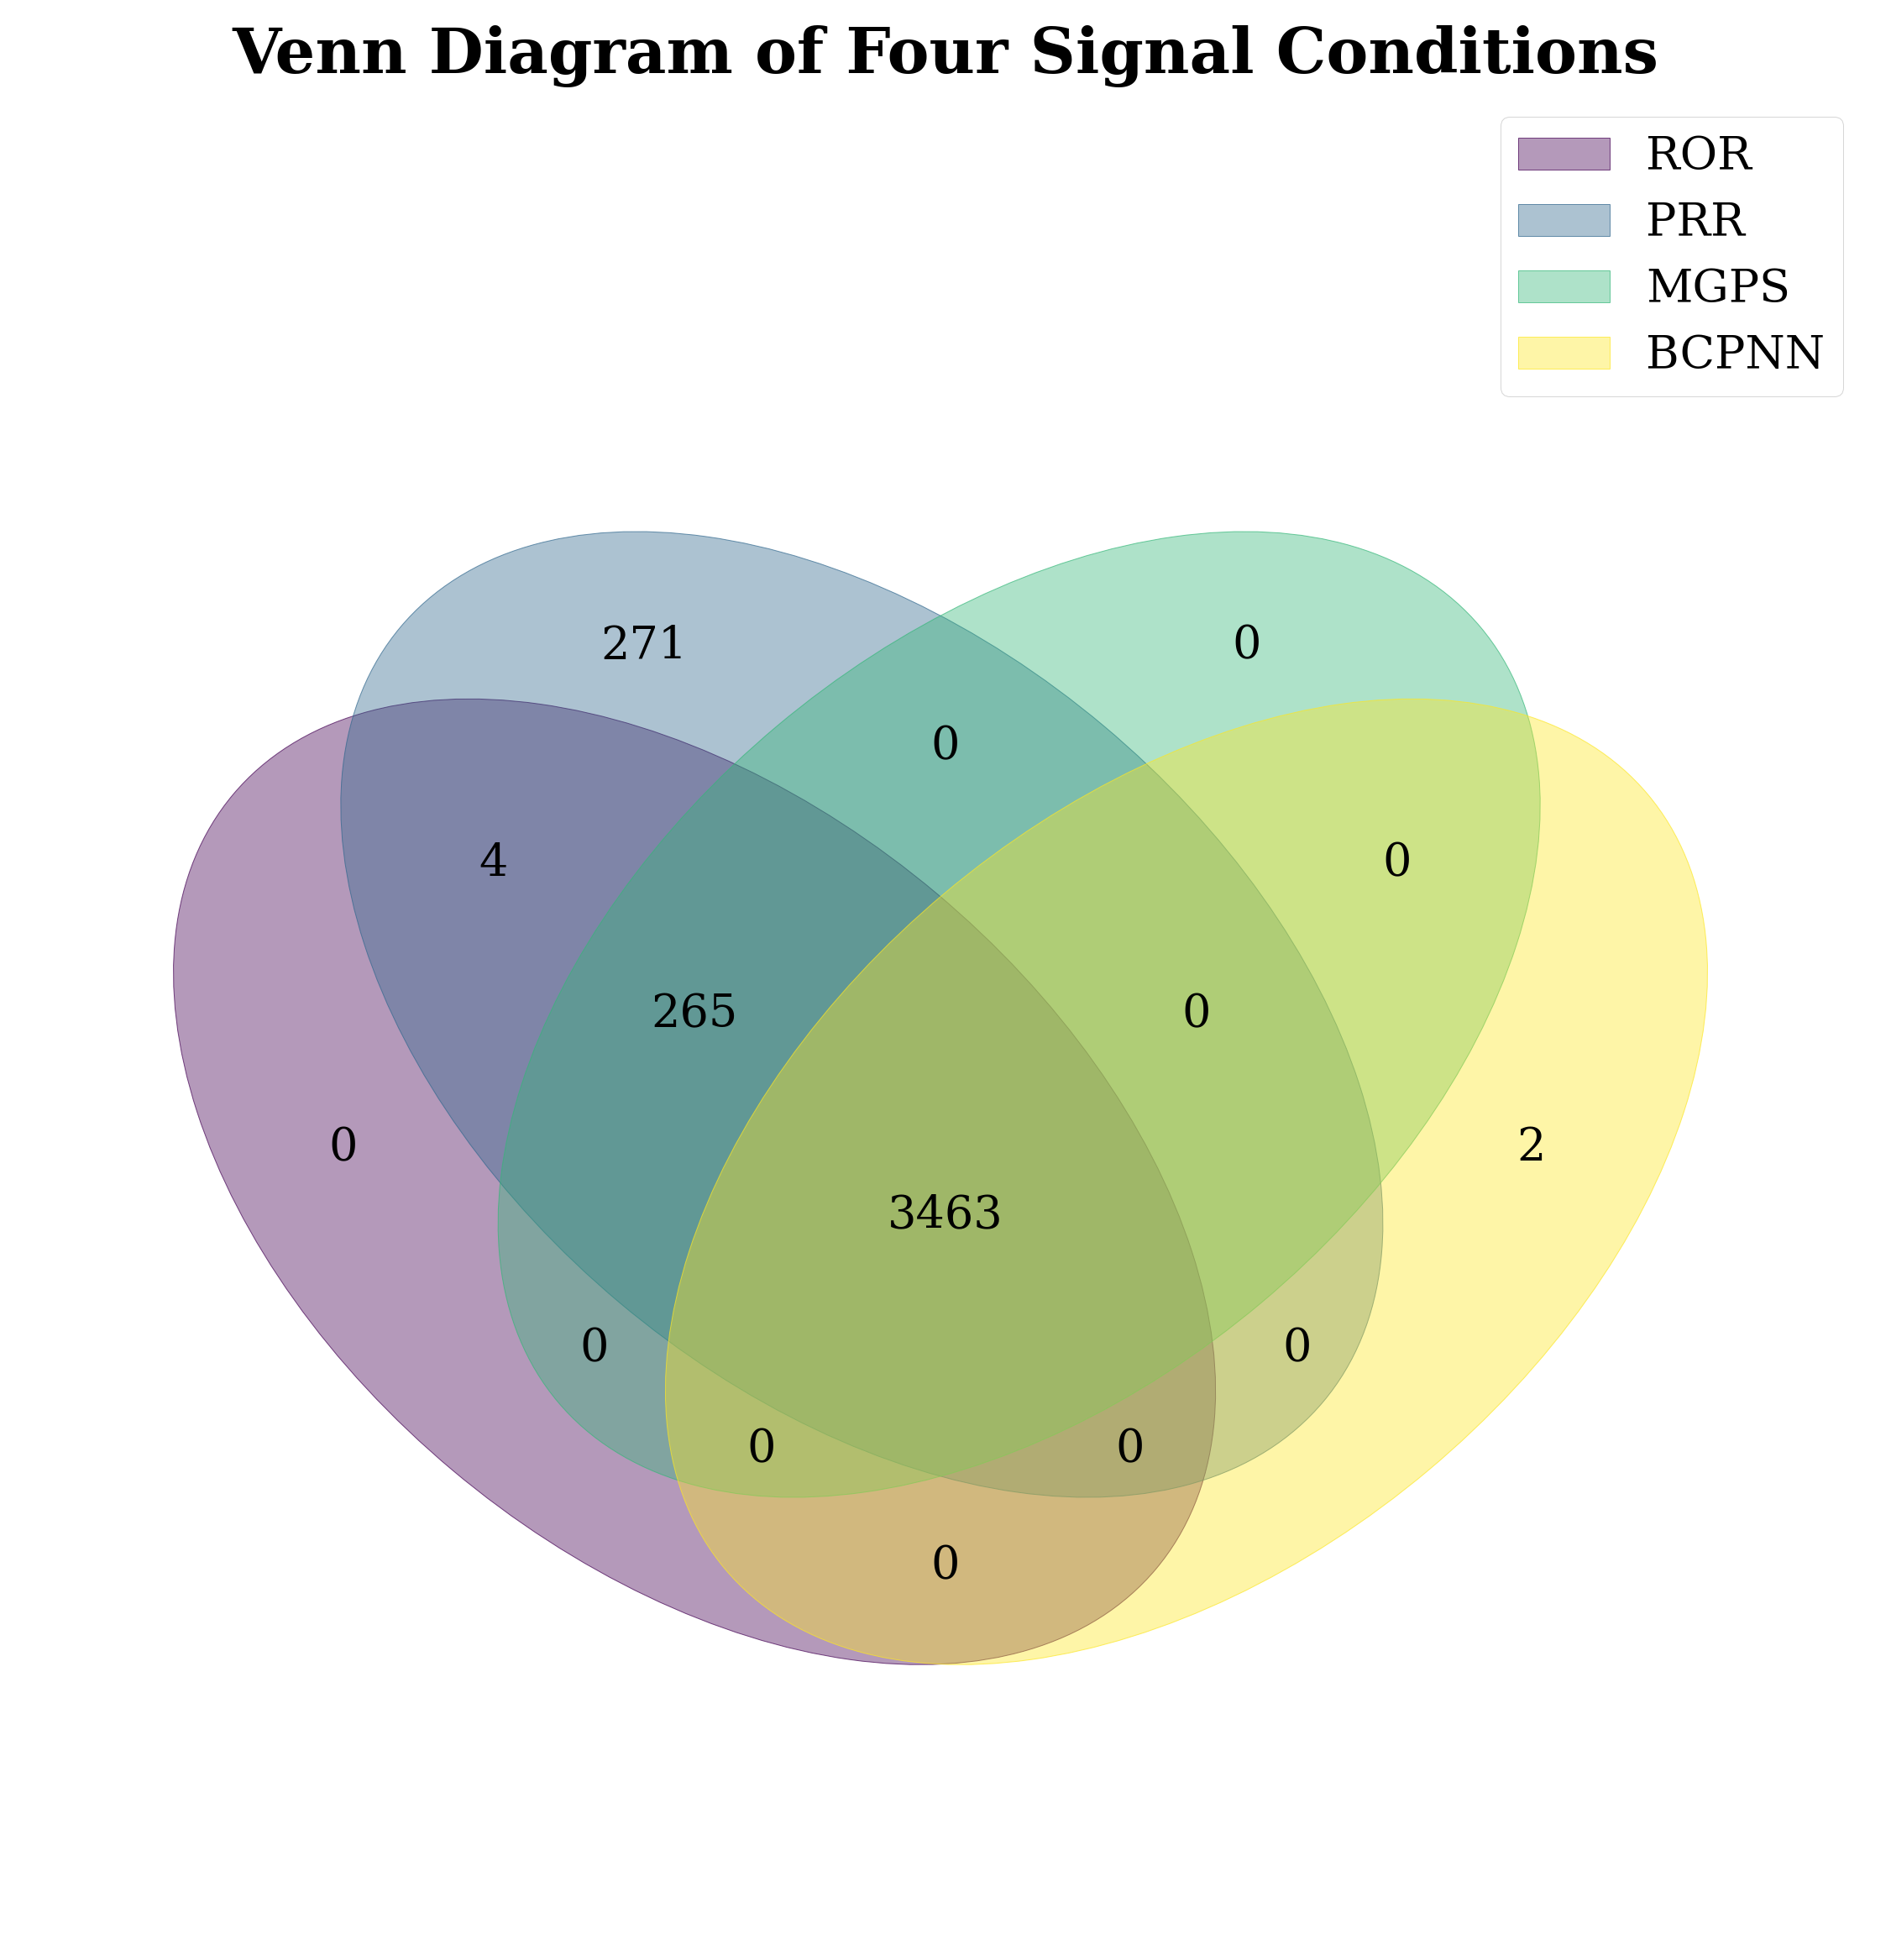

In [7]:
def plot_venn(data_path, output_path):

    signal_tmp_df = pd.read_excel(data_path)
    # Apply filters to get the sets
    # ror_set = set(ror_choose(signal_tmp_df).index)
    ror_set = set(signal_tmp_df[(signal_tmp_df['a'] >= 3) & (signal_tmp_df['ror_lower_bound'] > 1)].index)
    # prr_set = set(prr_choose(signal_tmp_df).index)
    prr_set = set(signal_tmp_df[(signal_tmp_df['a'] >= 3) & (signal_tmp_df['prr_lower_bound'] > 1)].index)
    # gps_set = set(gps_choose(signal_tmp_df).index)
    gps_set = set(signal_tmp_df[(signal_tmp_df['a'] >= 3) & (signal_tmp_df['EBGM05'] > 1)].index)
    # bcpnn_set = set(bcpnn_choose(signal_tmp_df).index)
    bcpnn_set = set(signal_tmp_df[(signal_tmp_df['a'] >= 3) & (signal_tmp_df['IC025'] > 0)].index)
    # Create a dictionary of sets for the venn library
    sets = {
        'ROR': ror_set,
        'PRR': prr_set,
        'MGPS': gps_set,
        'BCPNN': bcpnn_set
    }

    # Plot the Venn diagram
    plt.figure(figsize=(10, 10))
    venn(sets)
    plt.title("Venn Diagram of Four Signal Conditions", fontweight='bold', fontsize=18)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


plot_venn(f"{base_path}/MINING_REPORT/signal_tmp_pt.xlsx",
          f"{base_path}/VISUALIZATIONS/[1004]PT - VENN.png")

# **[1009] SOC - Frequency Bar Chart**

<ipython-input-8-5b96e56355e3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
<ipython-input-8-5b96e56355e3>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6, fontweight='bold')


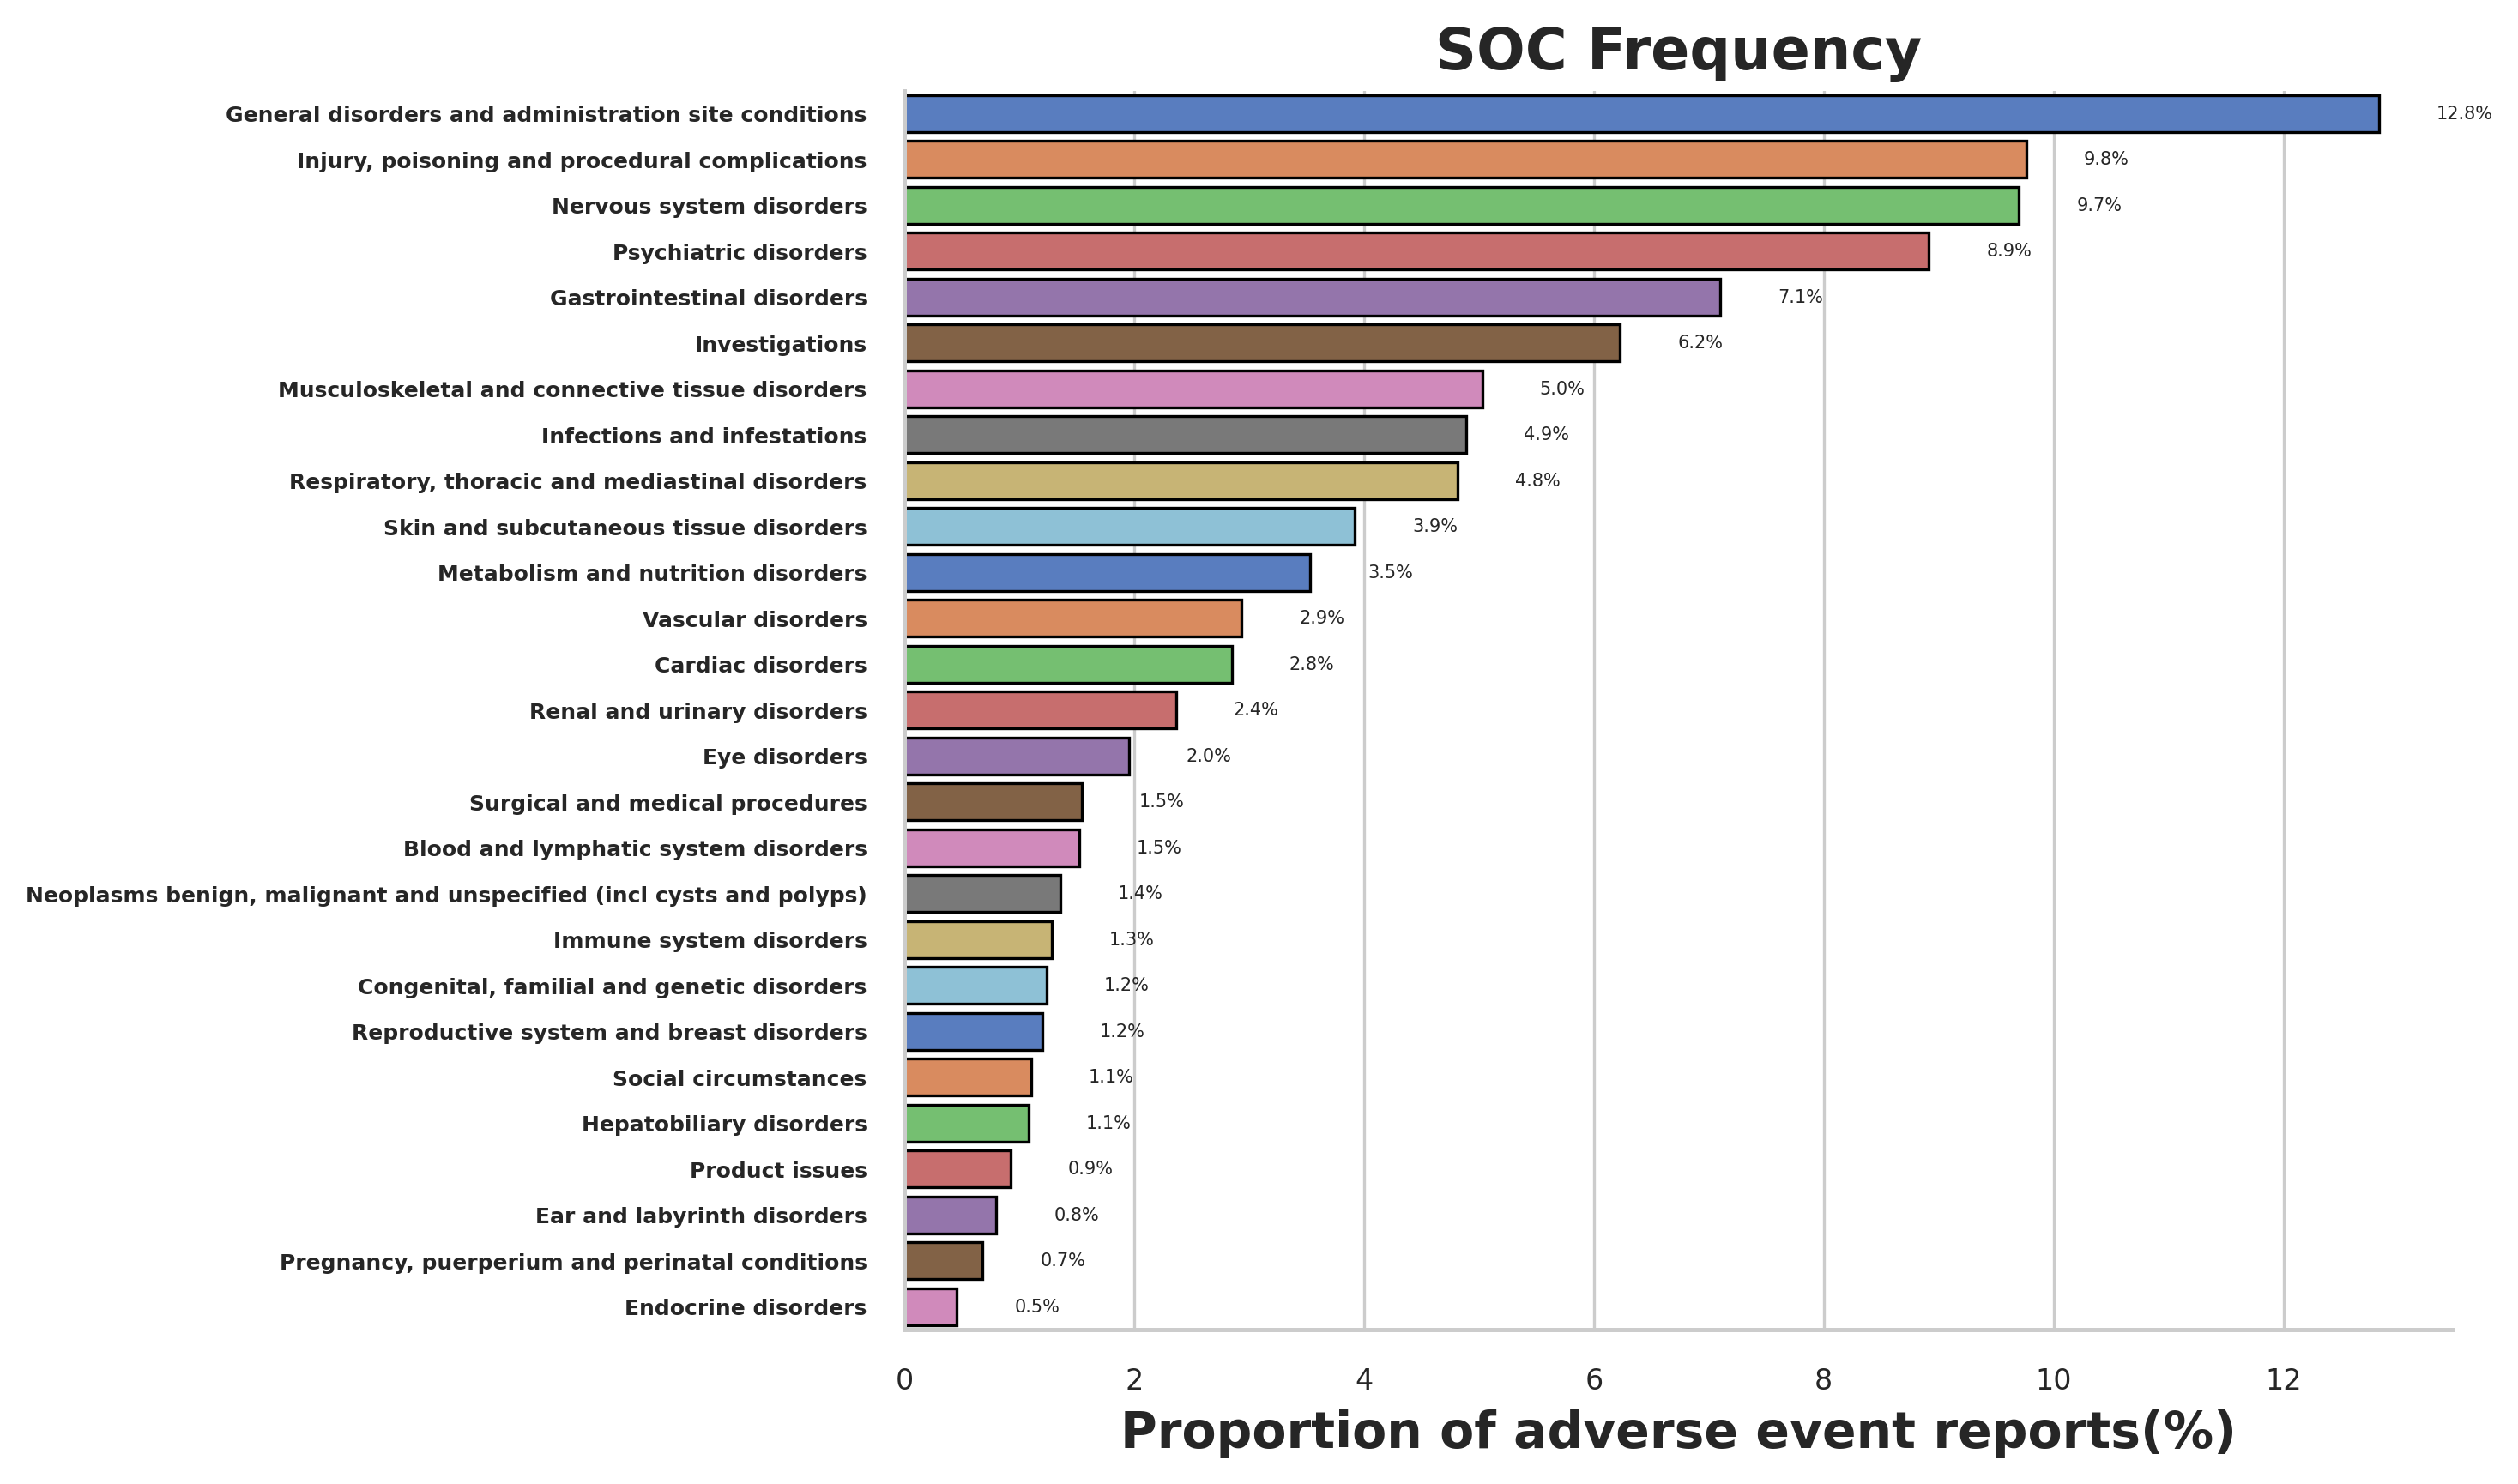

In [8]:
def plot_soc(data_path, output_path):
    df = pd.read_excel(data_path)

    df['percent'] = df['a'] / df['a'].sum() * 100

    sns.set(style="whitegrid", context="paper", font_scale=1.5)

    palette = sns.color_palette("muted", len(df))
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = sns.barplot(
        x="percent", y="SOC",
        data=df.sort_values('percent', ascending=False),
        palette=palette,
        edgecolor='black')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6, fontweight='bold')

    for i, (p, soc) in enumerate(zip(df.sort_values('percent', ascending=False)['percent'],
                                    df.sort_values('percent', ascending=False)['SOC'])):
        ax.text(p + 0.5, i, f"{p:.1f}%", va="center", fontsize=5)

    plt.xticks(fontsize=8)
    ax.set_xlabel("Proportion of adverse event reports(%)", fontsize=14, fontweight='bold')
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    plt.title("SOC Frequency", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_soc(f"{base_path}/MINING_REPORT/signal_tmp_soc.xlsx",
          f"{base_path}/VISUALIZATIONS/[1009]SOC_FREQUENCY.png")

# **[2003] DEMO_GOAL - Report Date Timeline Trend**

In [9]:
def plot_timeline(data_path, output_path):

    ext = os.path.splitext(data_path)[1].lower()
    if ext in ('.xls', '.xlsx'):
        df = pd.read_excel(data_path)
    else:
        df = pd.read_csv(data_path, encoding='utf-8', engine='python')

    df['year'] = pd.to_datetime(df['fda_dt'], format='%Y%m%d').dt.year

    # 2) Build full year-range index
    years = list(range(df['year'].min(), df['year'].max() + 1))
    annual_counts = df['year'].value_counts().reindex(years, fill_value=0).sort_index()

    fig, ax = plt.subplots(figsize=(12, 5))
    x = annual_counts.index
    y = annual_counts.values

    ax.plot(
        x, y,
        color='#2c7bb6',
        linewidth=2.5,
        marker='s',
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=1.5,
        zorder=3)

    ax.fill_between(
        x, y,
        color='#abd9e9',
        alpha=0.3,
        zorder=2)

    ax.set_xticks(x)
    ax.set_xticklabels([str(yr) for yr in x], rotation=45, ha='right', fontsize=10)

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(x[0] - 0.2, x[-1] + 0.2)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xlabel('Year', fontweight='semibold', fontsize = 14)
    ax.set_ylabel('Adverse Event Frequency', fontweight='semibold', fontsize=14)
    ax.set_title('Temporal Trends in Fluoxetine Adverse Event Reporting (2003-2024)', fontsize=18, fontweight='bold', pad=15)

    plt.tight_layout(pad=1.0)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()


# Run it
plot_timeline(f"{base_path}/RAW_DATA/DEMO_GOAL.xlsx",
              f"{base_path}/VISUALIZATIONS/[2003]AE_TIMELINE_TREND.png")



# **[2004] DEMO_GOAL - Gender Pie Chart**

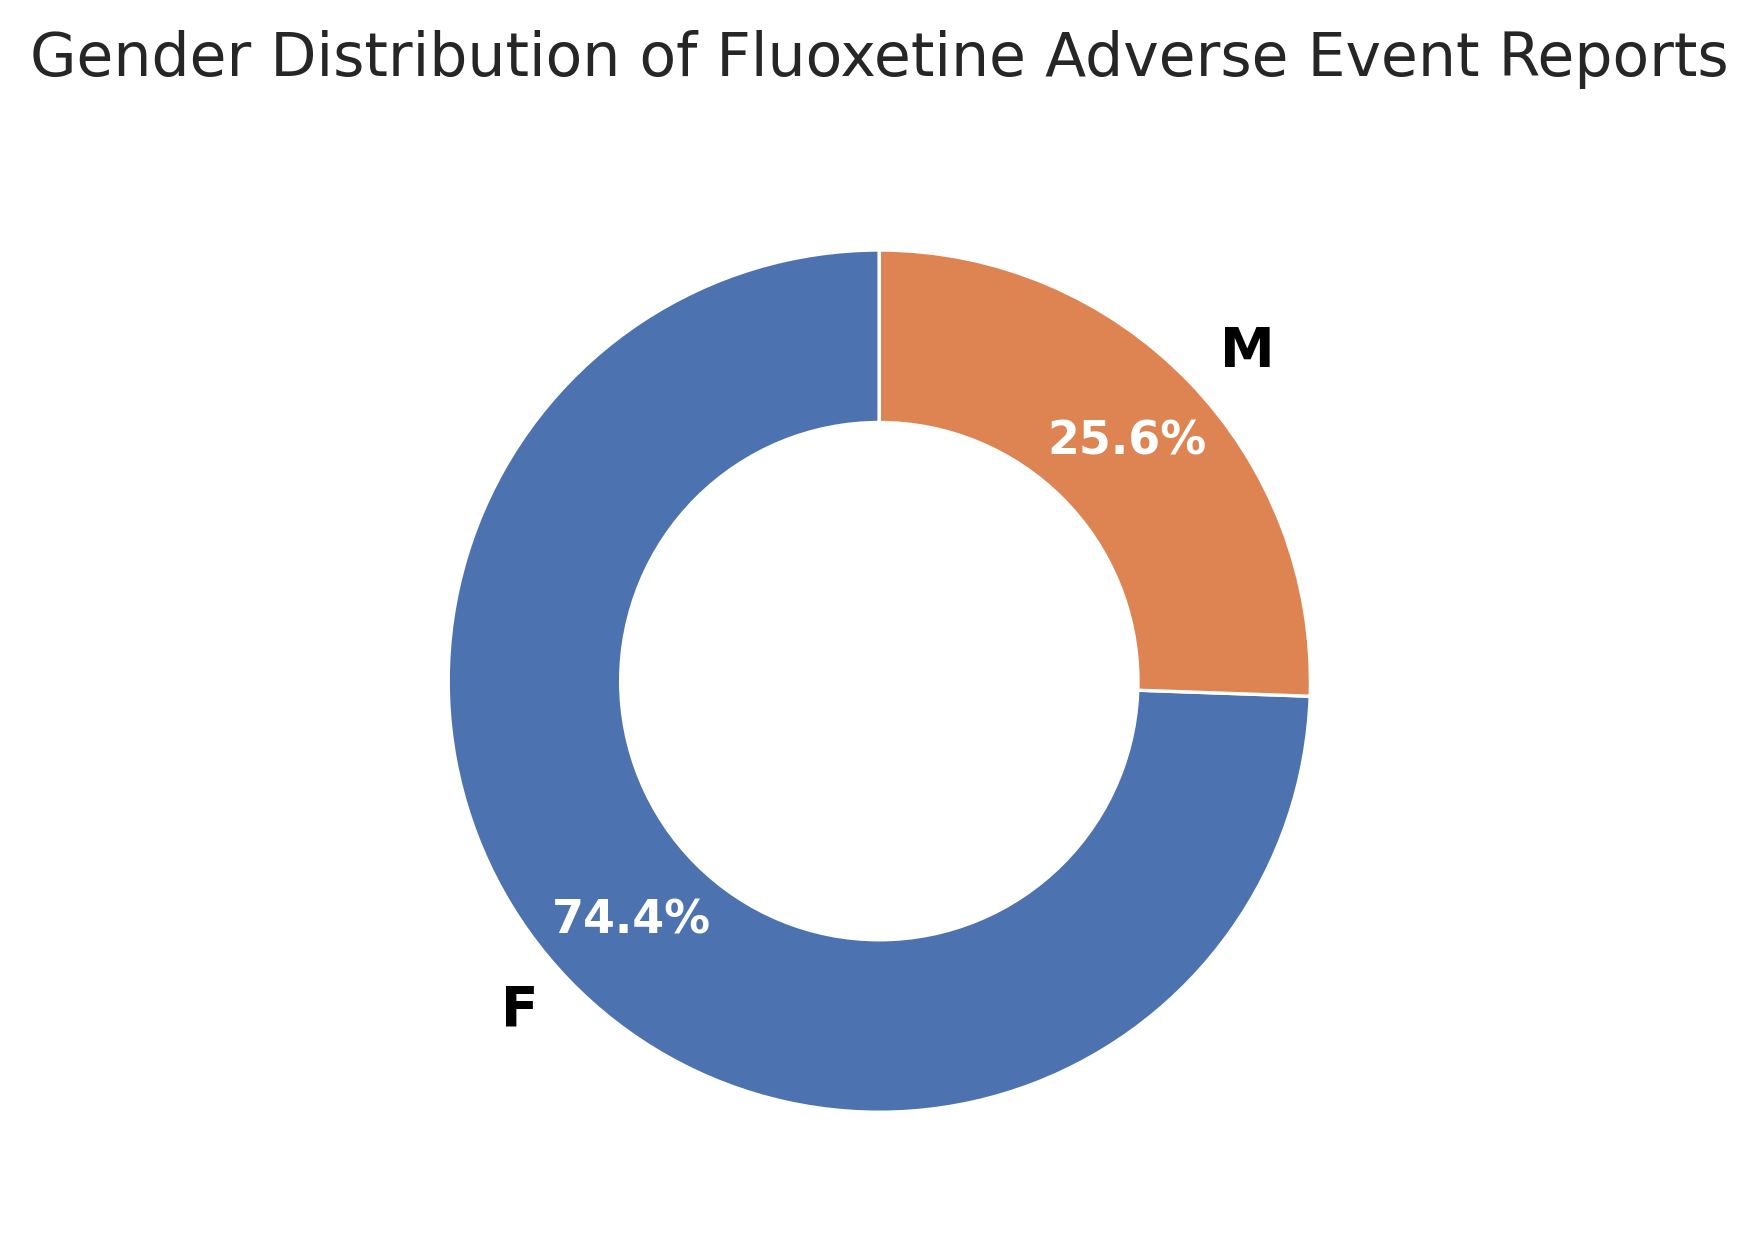

In [10]:
def plot_sex(data_path, output_path):

    ext = os.path.splitext(data_path)[1].lower()
    if ext in ('.xls', '.xlsx'):
        df = pd.read_excel(data_path)
    else:
        df = pd.read_csv(data_path, encoding='utf-8', engine='python')

    valid_sex = df[df['sex'].isin(['F', 'M'])]
    counts = valid_sex['sex'].value_counts().reindex(['F', 'M'])

    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=counts.index,
        colors=['#4C72B0', '#DD8452'],
        autopct='%.1f%%',
        startangle=90,
        textprops={'color': 'black', 'weight': 'semibold'},
        pctdistance=0.8)

    for autotext in autotexts:
        autotext.set_size(11)
        autotext.set_color('white')
    centre_circle = plt.Circle((0,0), 0.6, fc='white')
    ax.add_artist(centre_circle)
    ax.set_title('Gender Distribution of Fluoxetine Adverse Event Reports', pad=16)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_sex(f"{base_path}/RAW_DATA/DEMO_GOAL.xlsx",
        f"{base_path}/VISUALIZATIONS/[2004]GENDER.png")

# **[2005] DRUG_GOAL - Duration Days Weibull Distribution**

In [11]:
def plot_duration(data_path, output_path):

    df = pd.read_csv(data_path, encoding='utf-8', engine='python')
    if 'dur_days' not in df.columns:
        print("Error: no 'dur_days' column"); return

    clean_data = df['dur_days'].dropna()
    cutoff = clean_data.quantile(0.99)
    trimmed = clean_data[clean_data <= cutoff]

    # fit Weibull on trimmed data
    shape, loc, scale = stats.weibull_min.fit(trimmed, floc=0)

    median = scale * (np.log(2)) ** (1/shape)

    n_iterations = 100
    bootstrap_shape = np.zeros(n_iterations)
    bootstrap_scale = np.zeros(n_iterations)
    bootstrap_median = np.zeros(n_iterations)

    for i in range(n_iterations):
      sample = np.random.choice(clean_data, size=len(clean_data), replace=True)
      params = stats.weibull_min.fit(sample, floc=0)
      bootstrap_shape[i] = params[0]
      bootstrap_scale[i] = params[2]
      bootstrap_median[i] = params[2] * (np.log(2)) ** (1/params[0])

    shape_ci = np.percentile(bootstrap_shape, [2.5, 97.5])
    scale_ci = np.percentile(bootstrap_scale, [2.5, 97.5])
    median_ci = np.percentile(bootstrap_median, [2.5, 97.5])

    results = pd.DataFrame({
        'Parameter': ['Median', 'Scale parameter: a', 'Shape parameter: β'],
        'Mean': [round(median, 2), round(scale, 2), round(shape, 2)],
        '95% CI': [
            f"({round(median_ci[0], 2)}, {round(median_ci[1], 2)})",
            f"({round(scale_ci[0], 2)}, {round(scale_ci[1], 2)})",
            f"({round(shape_ci[0], 2)}, {round(shape_ci[1], 2)})"]})

    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(trimmed, bins=30, density=True,
            alpha=0.6, color='green',
            label='Observed (≤99th pct)')

    x = np.linspace(0, cutoff, 200)
    ax.plot(x, stats.weibull_min.pdf(x, shape, loc, scale),
            'r-', lw=2,
            label=f'Weibull (β={shape:.2f}, a={scale:.2f})')

    ax.set_xlim(0, cutoff)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_xlabel('Time‑to-Event‑Onset (days)', fontsize = 14, fontweight = 'bold')
    ax.set_ylabel('Density', fontsize =14, fontweight = 'bold')
    ax.set_title('Weibull Fit (0–99th percentile)', fontsize = 20, fontweight='bold')
    ax.legend()

    ax.legend()
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()



plot_duration(f"{base_path}/RAW_DATA/DRUG_GOAL2.csv",
              f"{base_path}/VISUALIZATIONS/[2005]DURATION_DAYS.png")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:2581: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


# **[2006] DEMO_GOAL - Top 10 Reporter Country Historgram**

<ipython-input-12-6683faed8636>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(country_counts))


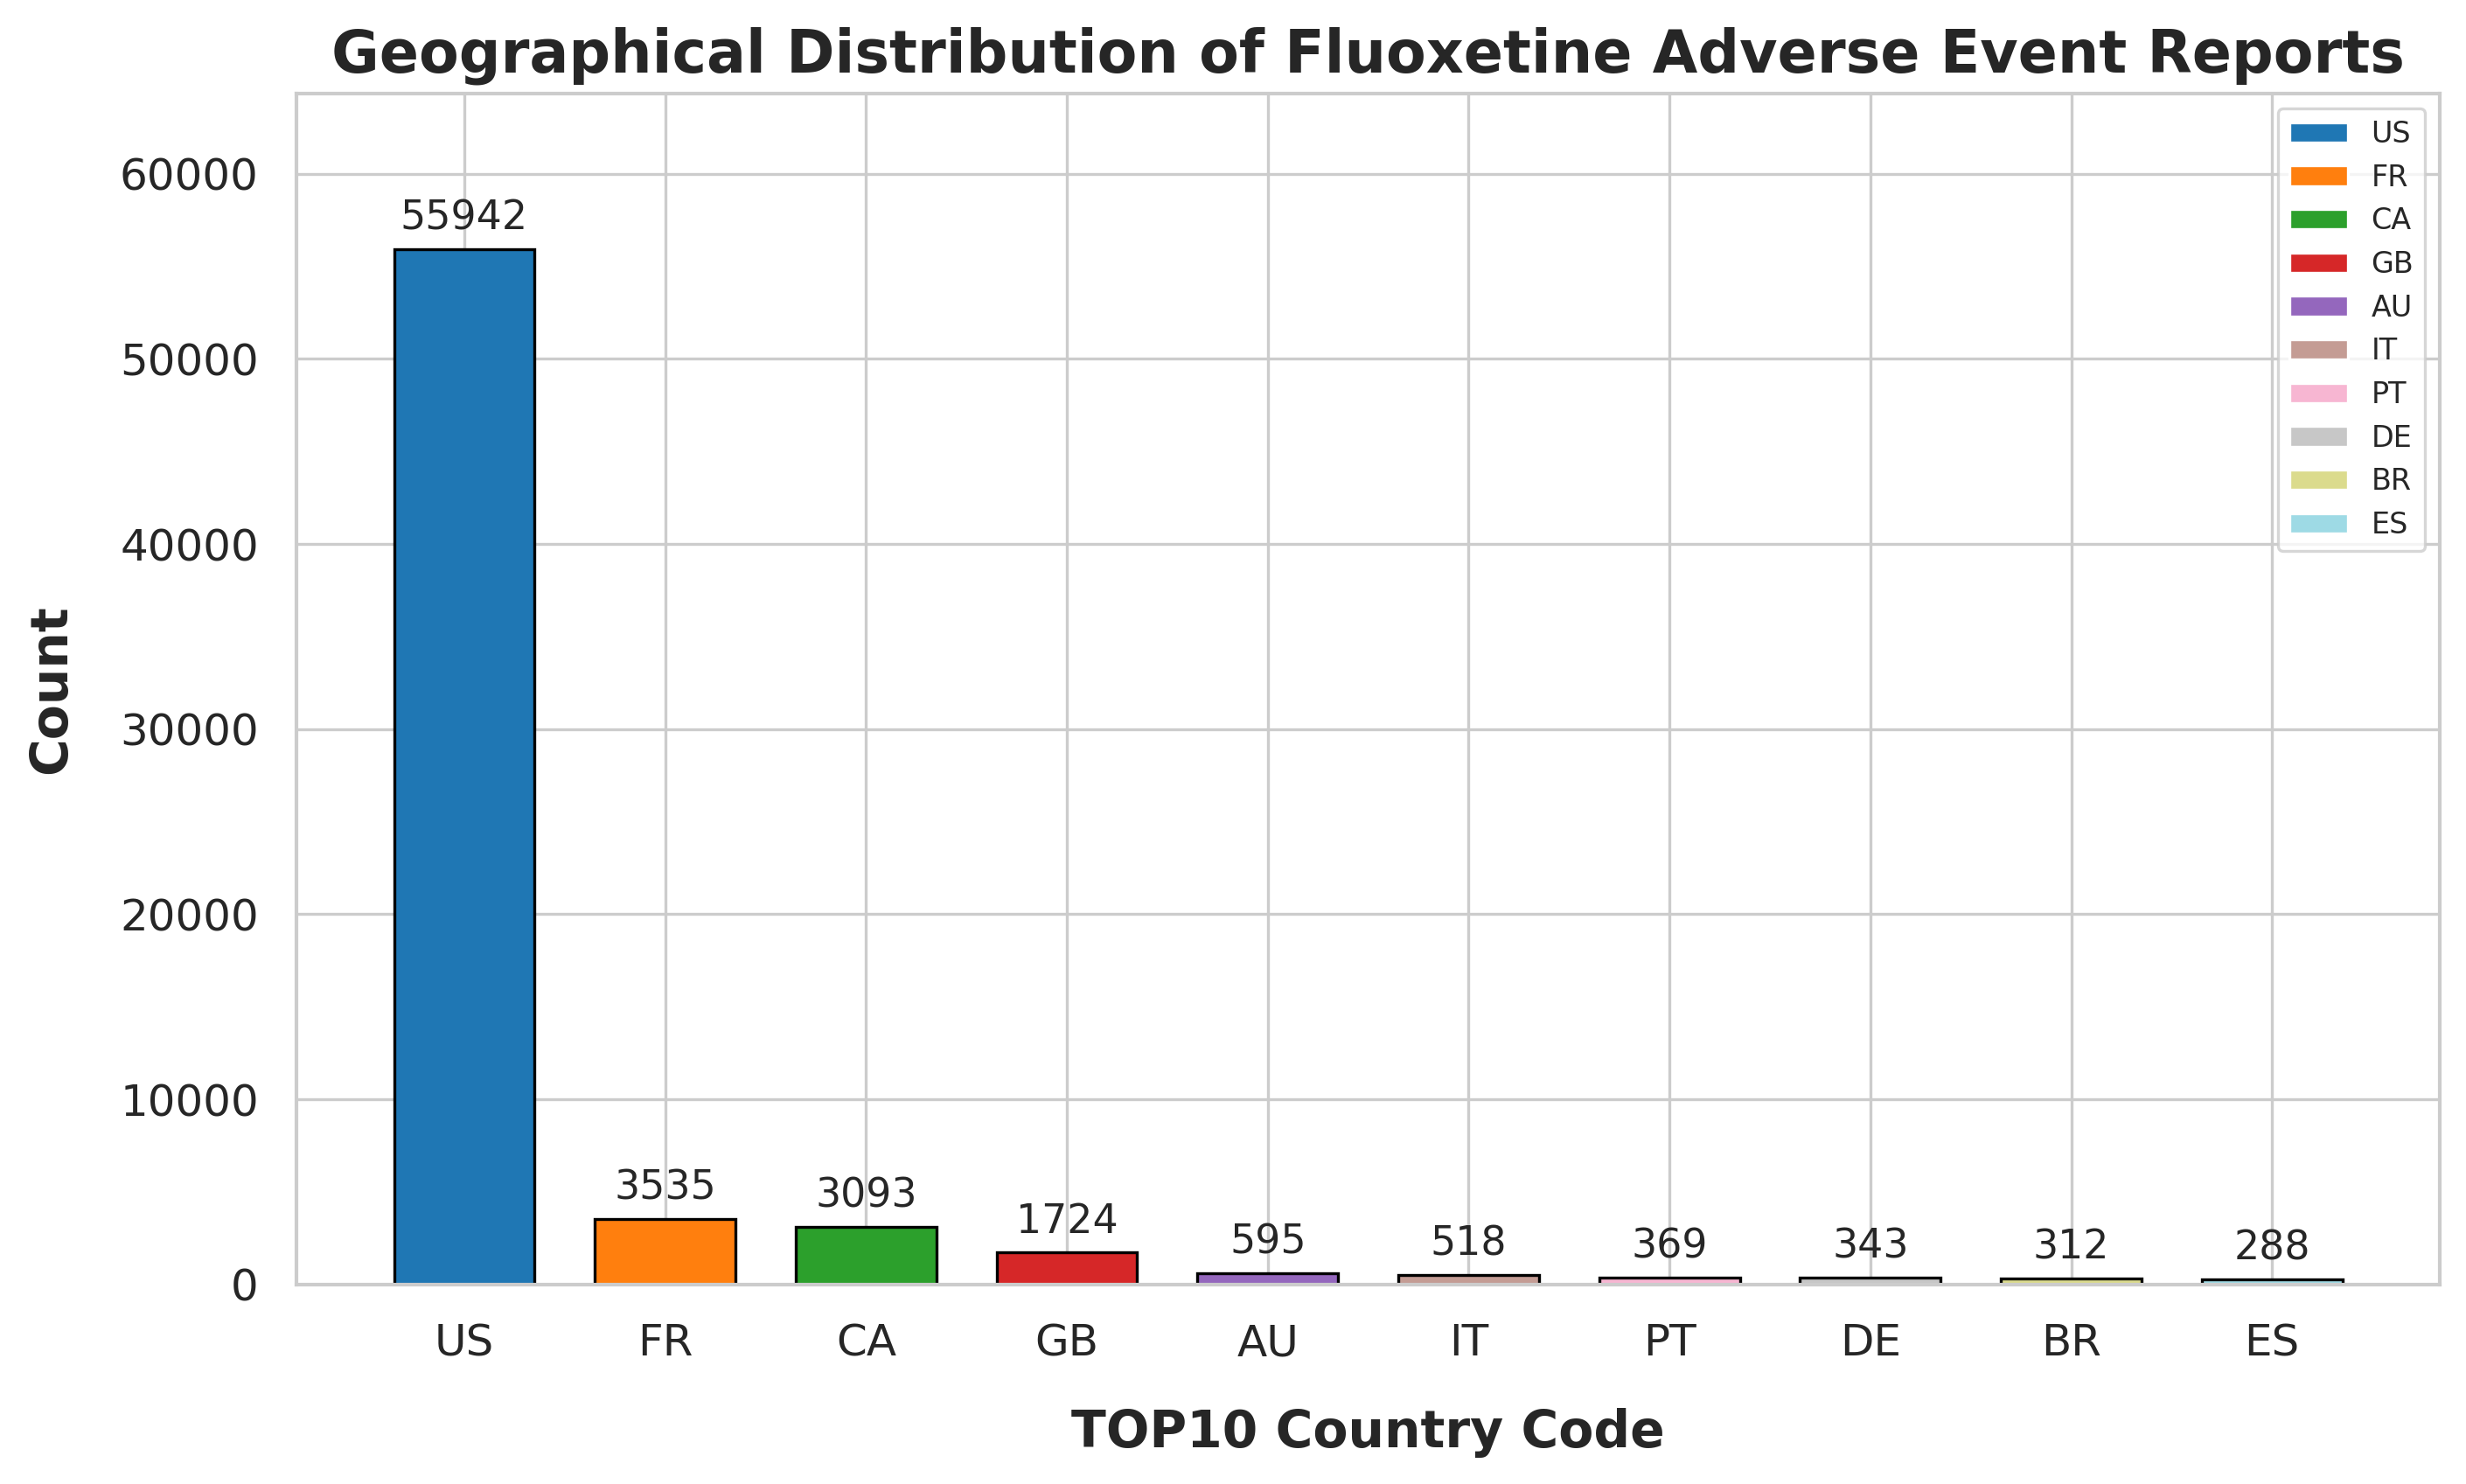

In [12]:
def plot_reporter_country(data_path, output_path):

    ext = os.path.splitext(data_path)[1].lower()
    if ext in ('.xls', '.xlsx'):
      df = pd.read_excel(data_path)
    else:
      df = pd.read_csv(data_path, encoding='utf-8', engine='python')

    df = df.dropna(subset=['reporter_country'])
    df['reporter_country'] = df['reporter_country'].astype(str).str.strip().str.upper()
    df = df[df['reporter_country'].str.len() == 2]
    country_counts = df['reporter_country'].value_counts().head(10)
    colors = plt.cm.get_cmap('tab20', len(country_counts))

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    bar_plot = ax.bar(
        country_counts.index,
        country_counts.values,
        color=colors(range(len(country_counts))), # Applying the colormap
        edgecolor='black',
        linewidth=0.8,
        width=0.7)

    country_code_map = {
        "US": "United States",
        "CA": "Canada",
        "GB": "United Kingdom",
        "DE": "Germany",
        "AU": "Australia",
        "FR": "France",
        "ES": "Spain",
        # Add more mappings as needed
    }

    legend_elements = [Patch(facecolor=colors(i), label=country)
                       for i, country in enumerate(country_counts.index)]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    ax.set_xlabel('TOP10 Country Code', fontsize=14, fontweight='bold', labelpad=12)
    ax.set_ylabel('Count', fontsize=14, fontweight='bold', labelpad=12)
    ax.tick_params(axis='both', which='major', labelsize=12, direction='out')

    ax.bar_label(
        bar_plot,
        labels=country_counts.values,
        padding=3,
        fontsize=11,
        fmt='%d')
    plt.ylim(0, country_counts.max() * 1.15)
    plt.tight_layout(pad=2.0)
    plt.title('Geographical Distribution of Fluoxetine Adverse Event Reports', fontsize=16, fontweight='bold')
    plt.savefig(output_path)
    plt.show()


plot_reporter_country(f"{base_path}/RAW_DATA/DEMO_GOAL.xlsx",
                      f"{base_path}/VISUALIZATIONS/[2006]REPORTER_COUNTRY.png")

# **[2007] DEMO_GOAL - Occurred Country Pie Chart**

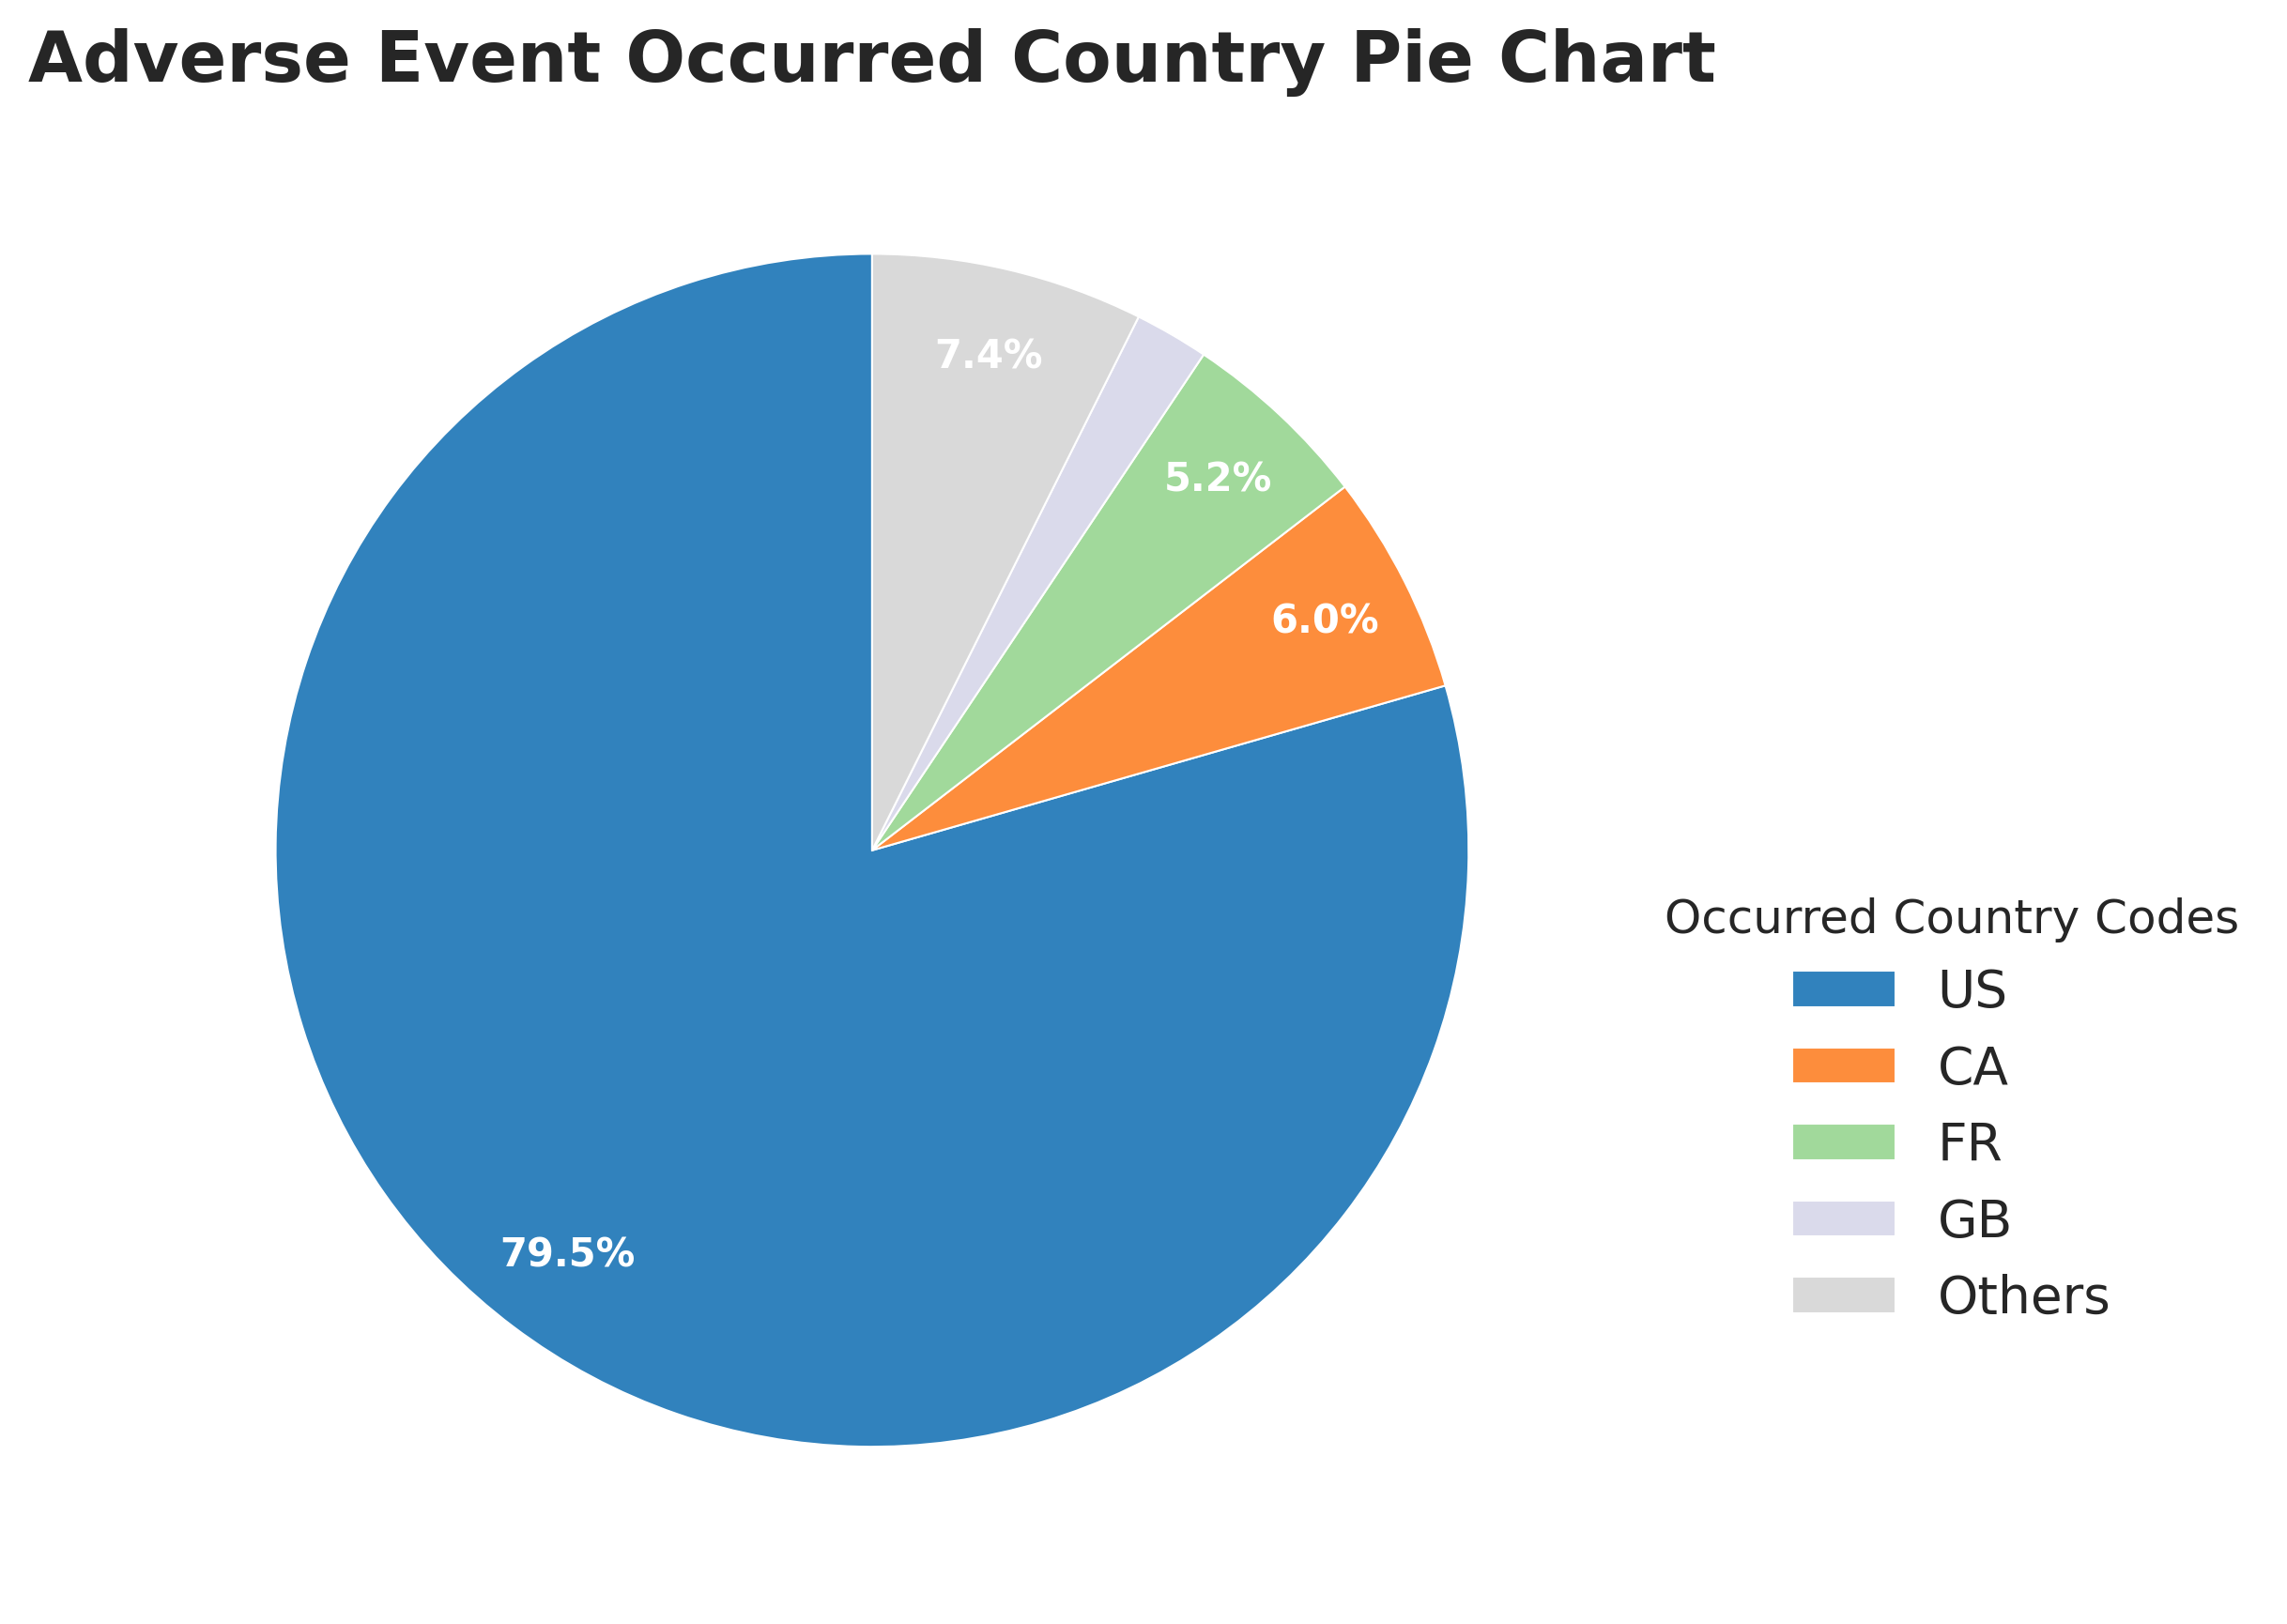

In [13]:
def plot_occurred_country(data_path, output_path):

    ext = os.path.splitext(data_path)[1].lower()
    if ext in ('.xls', '.xlsx'):
      df = pd.read_excel(data_path)
    else:
      df = pd.read_csv(data_path, encoding='utf-8', engine='python')
    data = df['occr_country'].dropna().value_counts()

    threshold = 0.02 * data.sum()
    filtered = data[data >= threshold]
    other = pd.Series([data[data < threshold].sum()], index=['Others']) if (data < threshold).any() else pd.Series()
    combined = pd.concat([filtered, other])

    colors = plt.cm.tab20c(np.linspace(0, 1, len(combined)))
    fig, ax = plt.subplots(figsize=(8, 6))
    wedges, texts, autotexts = ax.pie(
        combined,
        labels=None,
        colors=colors,
        startangle=90,
        autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        pctdistance=0.85,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})

    legend = ax.legend(
        wedges,
        combined.index,
        title='Occurred Country Codes',
        loc='best',
        bbox_to_anchor=(1, 0.5),
        frameon=False,
        title_fontsize=12)

    plt.setp(autotexts, size=10, color='white', weight='bold')
    plt.title('Adverse Event Occurred Country Pie Chart', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


plot_occurred_country(f"{base_path}/RAW_DATA/DEMO_GOAL.xlsx",
                      f"{base_path}/VISUALIZATIONS/[2007]OCCURRED_COUNTRY.png")

# **[2008] DEMO_GOAL - Age Group Distribution**

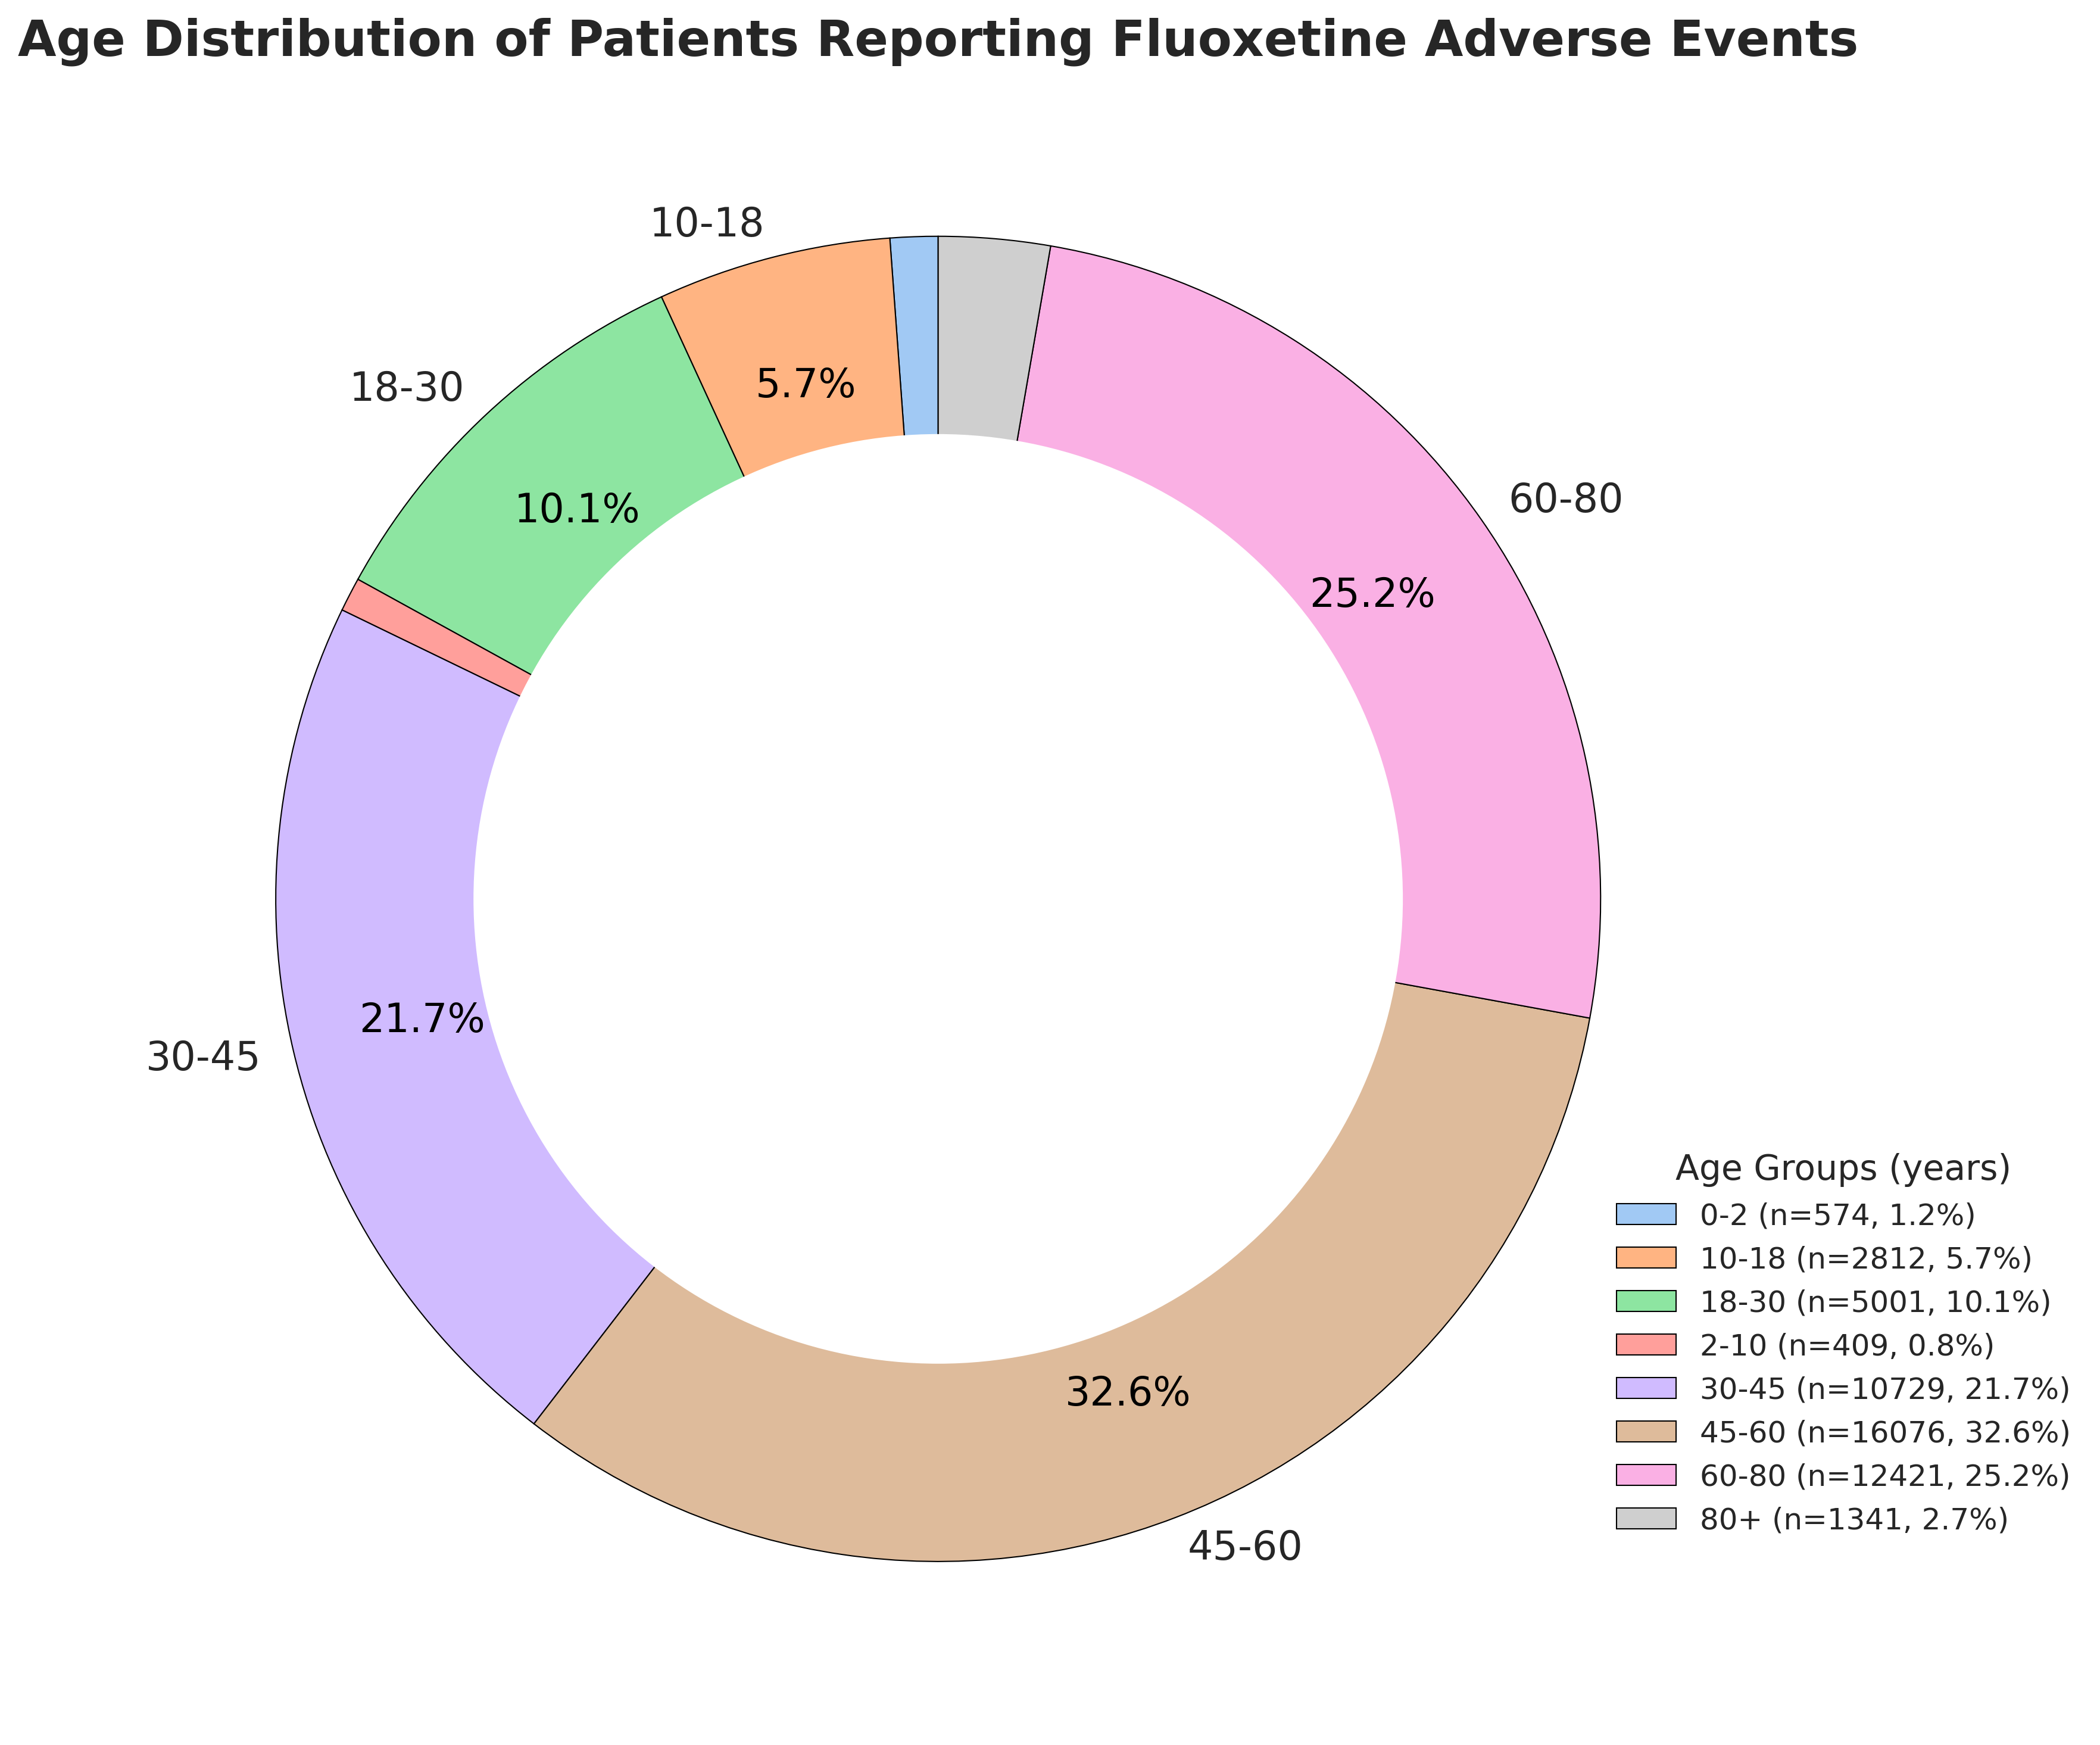

In [14]:
def plot_age(data_path, output_path):

    ext = os.path.splitext(data_path)[1].lower()
    if ext in ('.xls', '.xlsx'):
        df = pd.read_excel(data_path)
    else:
        df = pd.read_csv(data_path, encoding='utf-8', engine='python')

    filtered_data = df['age_group'].dropna()
    filtered_data = filtered_data[filtered_data != 'Missing']
    filtered_data = filtered_data[filtered_data != '--']

    counts = filtered_data.value_counts().sort_index()
    percentages = 100 * counts / counts.sum()
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
    labels = [label if percentages.loc[label] >=5 else '' for label in counts.index]

    wedges, texts, autotexts = ax.pie(
        counts,
        labels=labels,
        autopct=lambda p: f'{p:.1f}%' if p >=5 else '',
        startangle=90,
        colors=sns.color_palette("pastel"),
        pctdistance=0.8,
        labeldistance=1.05,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},
        textprops={'fontsize': 16})

    for autotext in autotexts:
        if autotext.get_text() == '':
            autotext.set_visible(False)
        else:
            autotext.set_color('black')
            autotext.set_fontsize(16)
            autotext.set_fontstyle('normal')

    centre_circle = plt.Circle((0,0), 0.7, fc='white')
    ax.add_artist(centre_circle)

    ax.legend(
        wedges,
        [f"{l} (n={c}, {p:.1f}%)" for l, c, p in zip(counts.index, counts, percentages)],
        title="Age Groups (years)",
        loc='lower right',
        bbox_to_anchor=(1.2, 0.1),
        frameon=False,
        fontsize=12,
        title_fontsize=14)
    plt.title("Age Distribution of Patients Reporting Fluoxetine Adverse Events", fontsize=20,fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


plot_age(f"{base_path}/RAW_DATA/DEMO_GOAL.xlsx",
         f"{base_path}/VISUALIZATIONS/[2008]AGE_GROUP.png")

# **[2009] DEMO_GOAL - Weight Group Distribution**

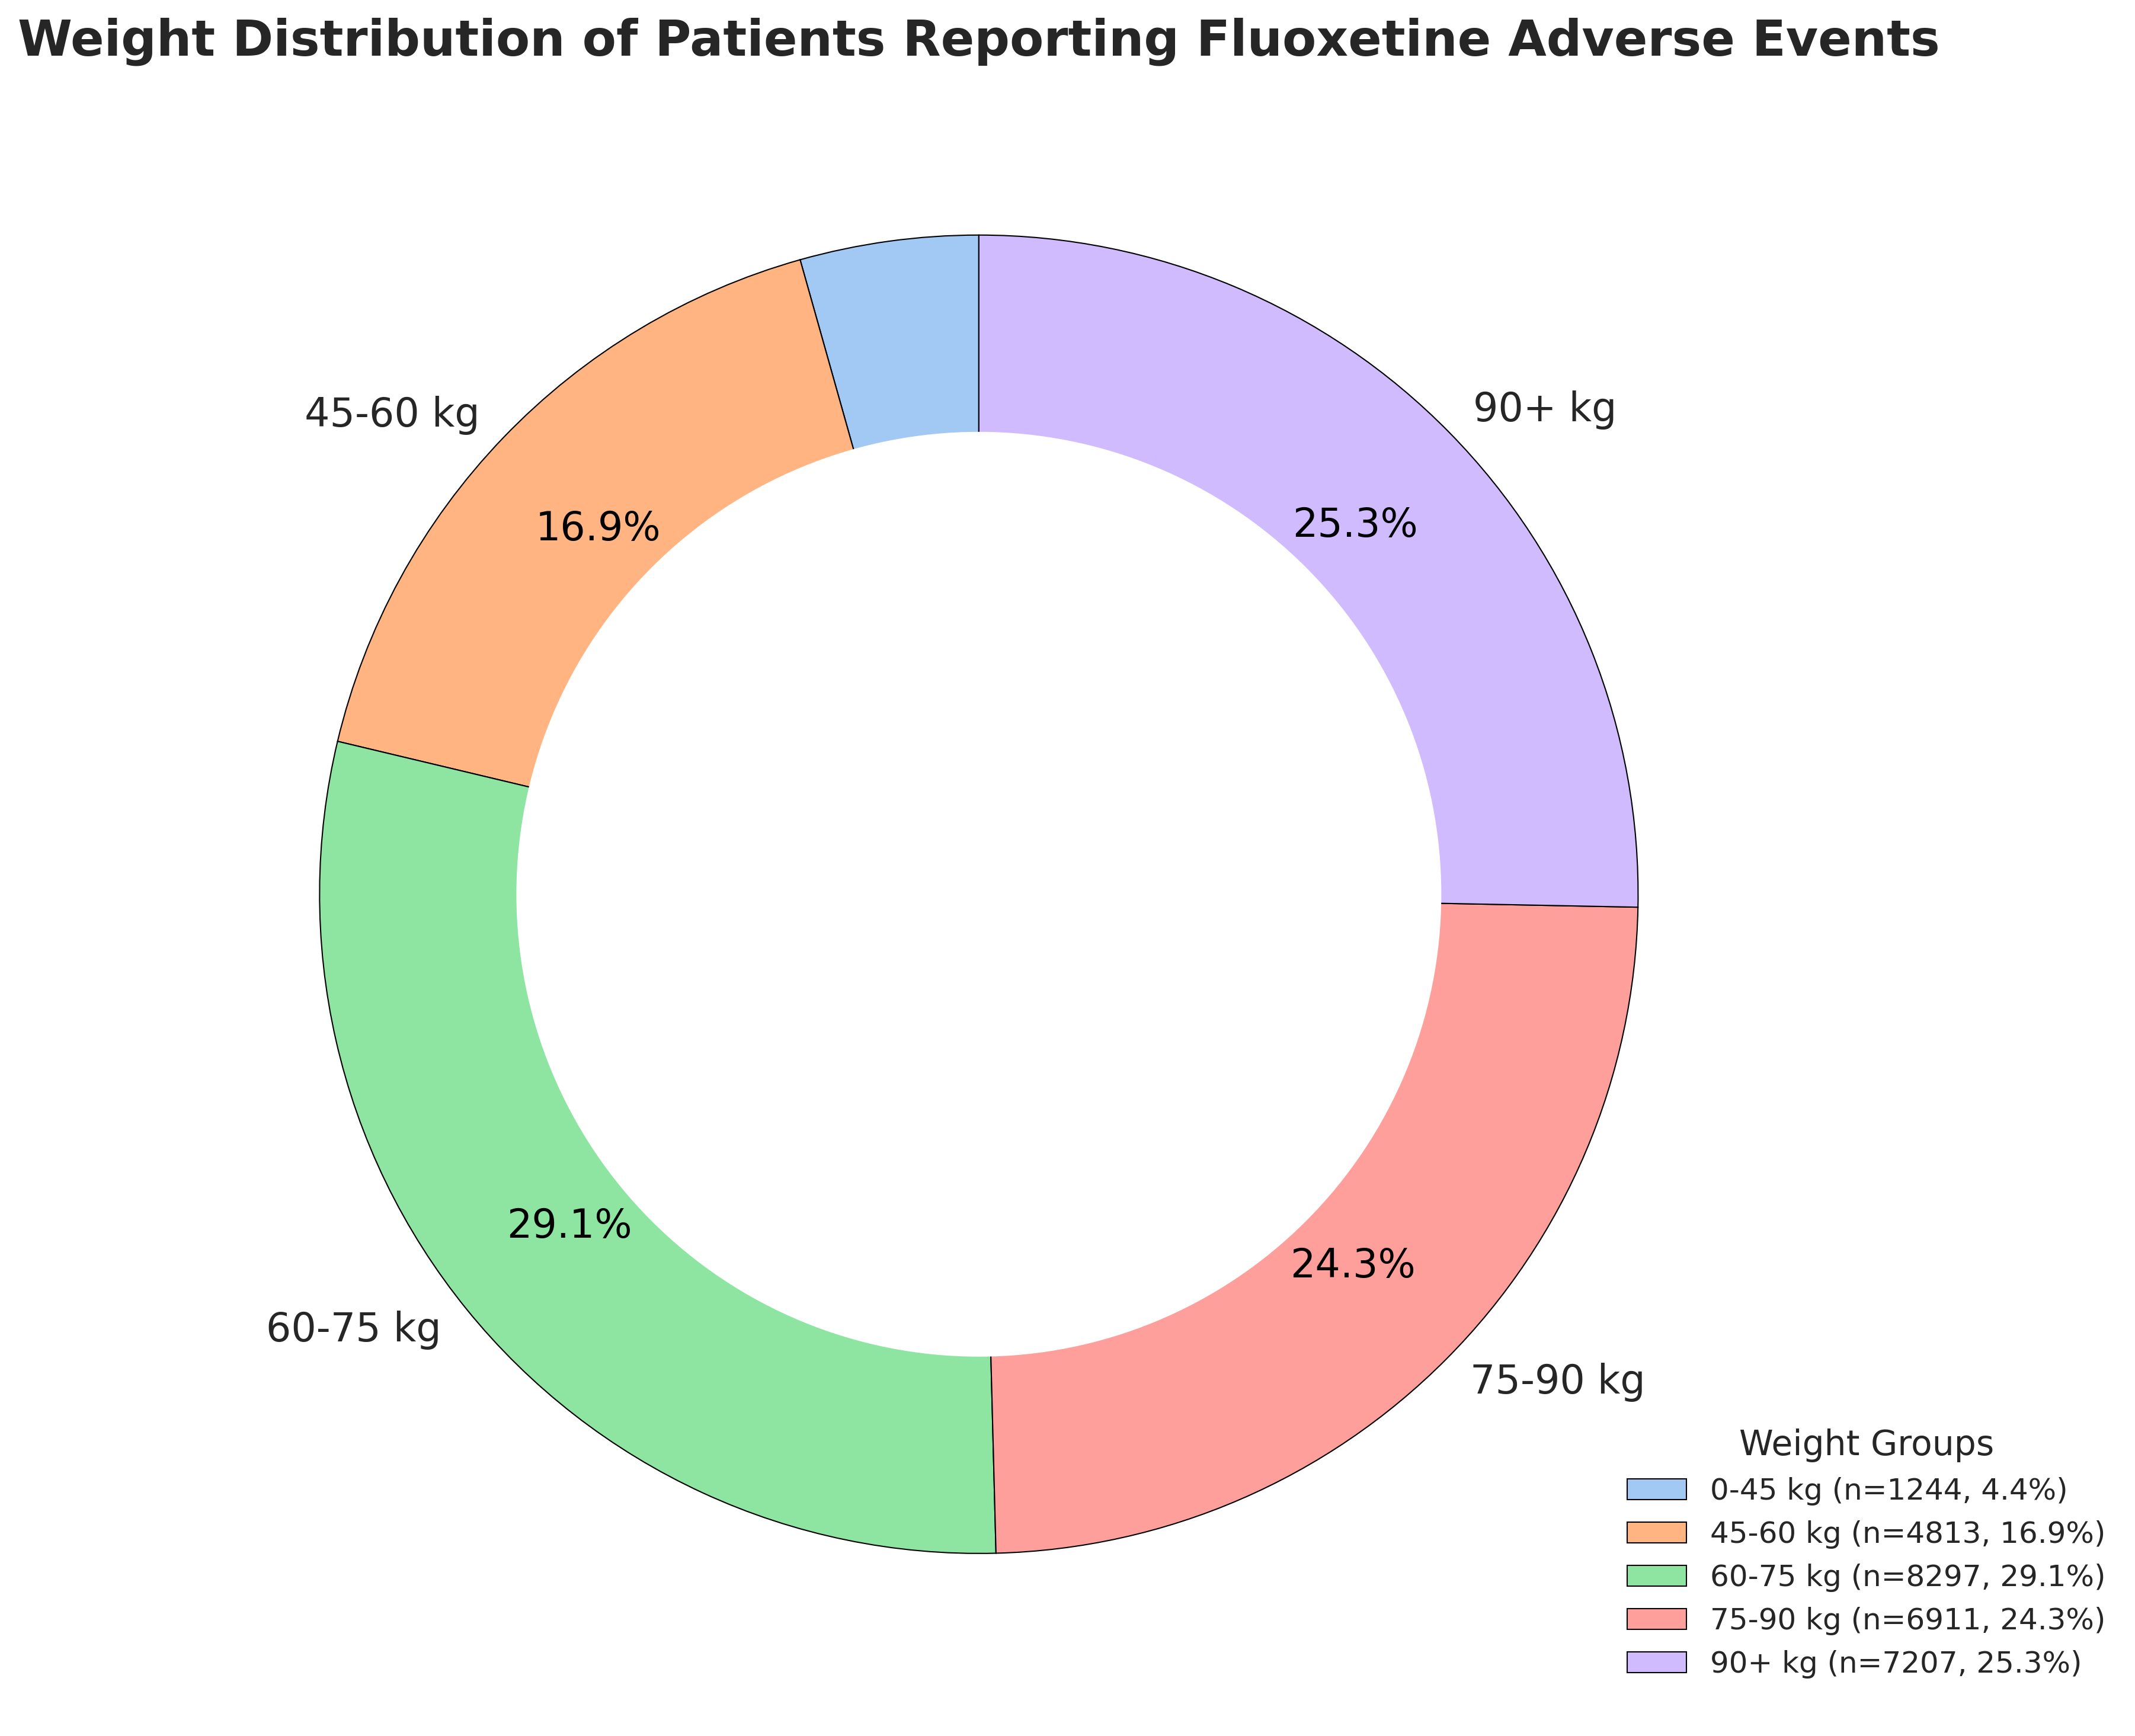

In [15]:
def plot_weight(data_path, output_path):

    ext = os.path.splitext(data_path)[1].lower()
    if ext in ('.xls', '.xlsx'):
        df = pd.read_excel(data_path)
    else:
        df = pd.read_csv(data_path, encoding='utf-8', engine='python')

    filtered_data = df['weight_group'].dropna()
    filtered_data = filtered_data[filtered_data != 'Missing']
    filtered_data = filtered_data[filtered_data != '--']

    counts = filtered_data.value_counts().sort_index()
    percentages = 100 * counts / counts.sum()


    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
    labels = [label if percentages.loc[label] >=5 else '' for label in counts.index]

    wedges, texts, autotexts = ax.pie(
        counts,
        labels=labels,
        autopct=lambda p: f'{p:.1f}%' if p >=5 else '',
        startangle=90,
        colors=sns.color_palette("pastel"),
        pctdistance=0.8,
        labeldistance=1.05,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},
        textprops={'fontsize': 16})


    for autotext in autotexts:
        if autotext.get_text() == '':
            autotext.set_visible(False)
        else:
            autotext.set_color('black')
            autotext.set_fontsize(16)
            autotext.set_fontstyle('normal')

    centre_circle = plt.Circle((0,0), 0.7, fc='white')
    ax.add_artist(centre_circle)

    ax.legend(
        wedges,
        [f"{l} (n={c}, {p:.1f}%)" for l, c, p in zip(counts.index, counts, percentages)],
        title="Weight Groups",
        loc='lower right',
        bbox_to_anchor=(1.2, 0.008),
        frameon=False,
        fontsize=12,
        title_fontsize=14)
    plt.title("Weight Distribution of Patients Reporting Fluoxetine Adverse Events", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_weight(f"{base_path}/RAW_DATA/DEMO_GOAL.xlsx",
            f"{base_path}/VISUALIZATIONS/[2009]WEIGHT_GROUP.png")

# **[3001] DUGR_GOAL2 - Duration Days Frequency**

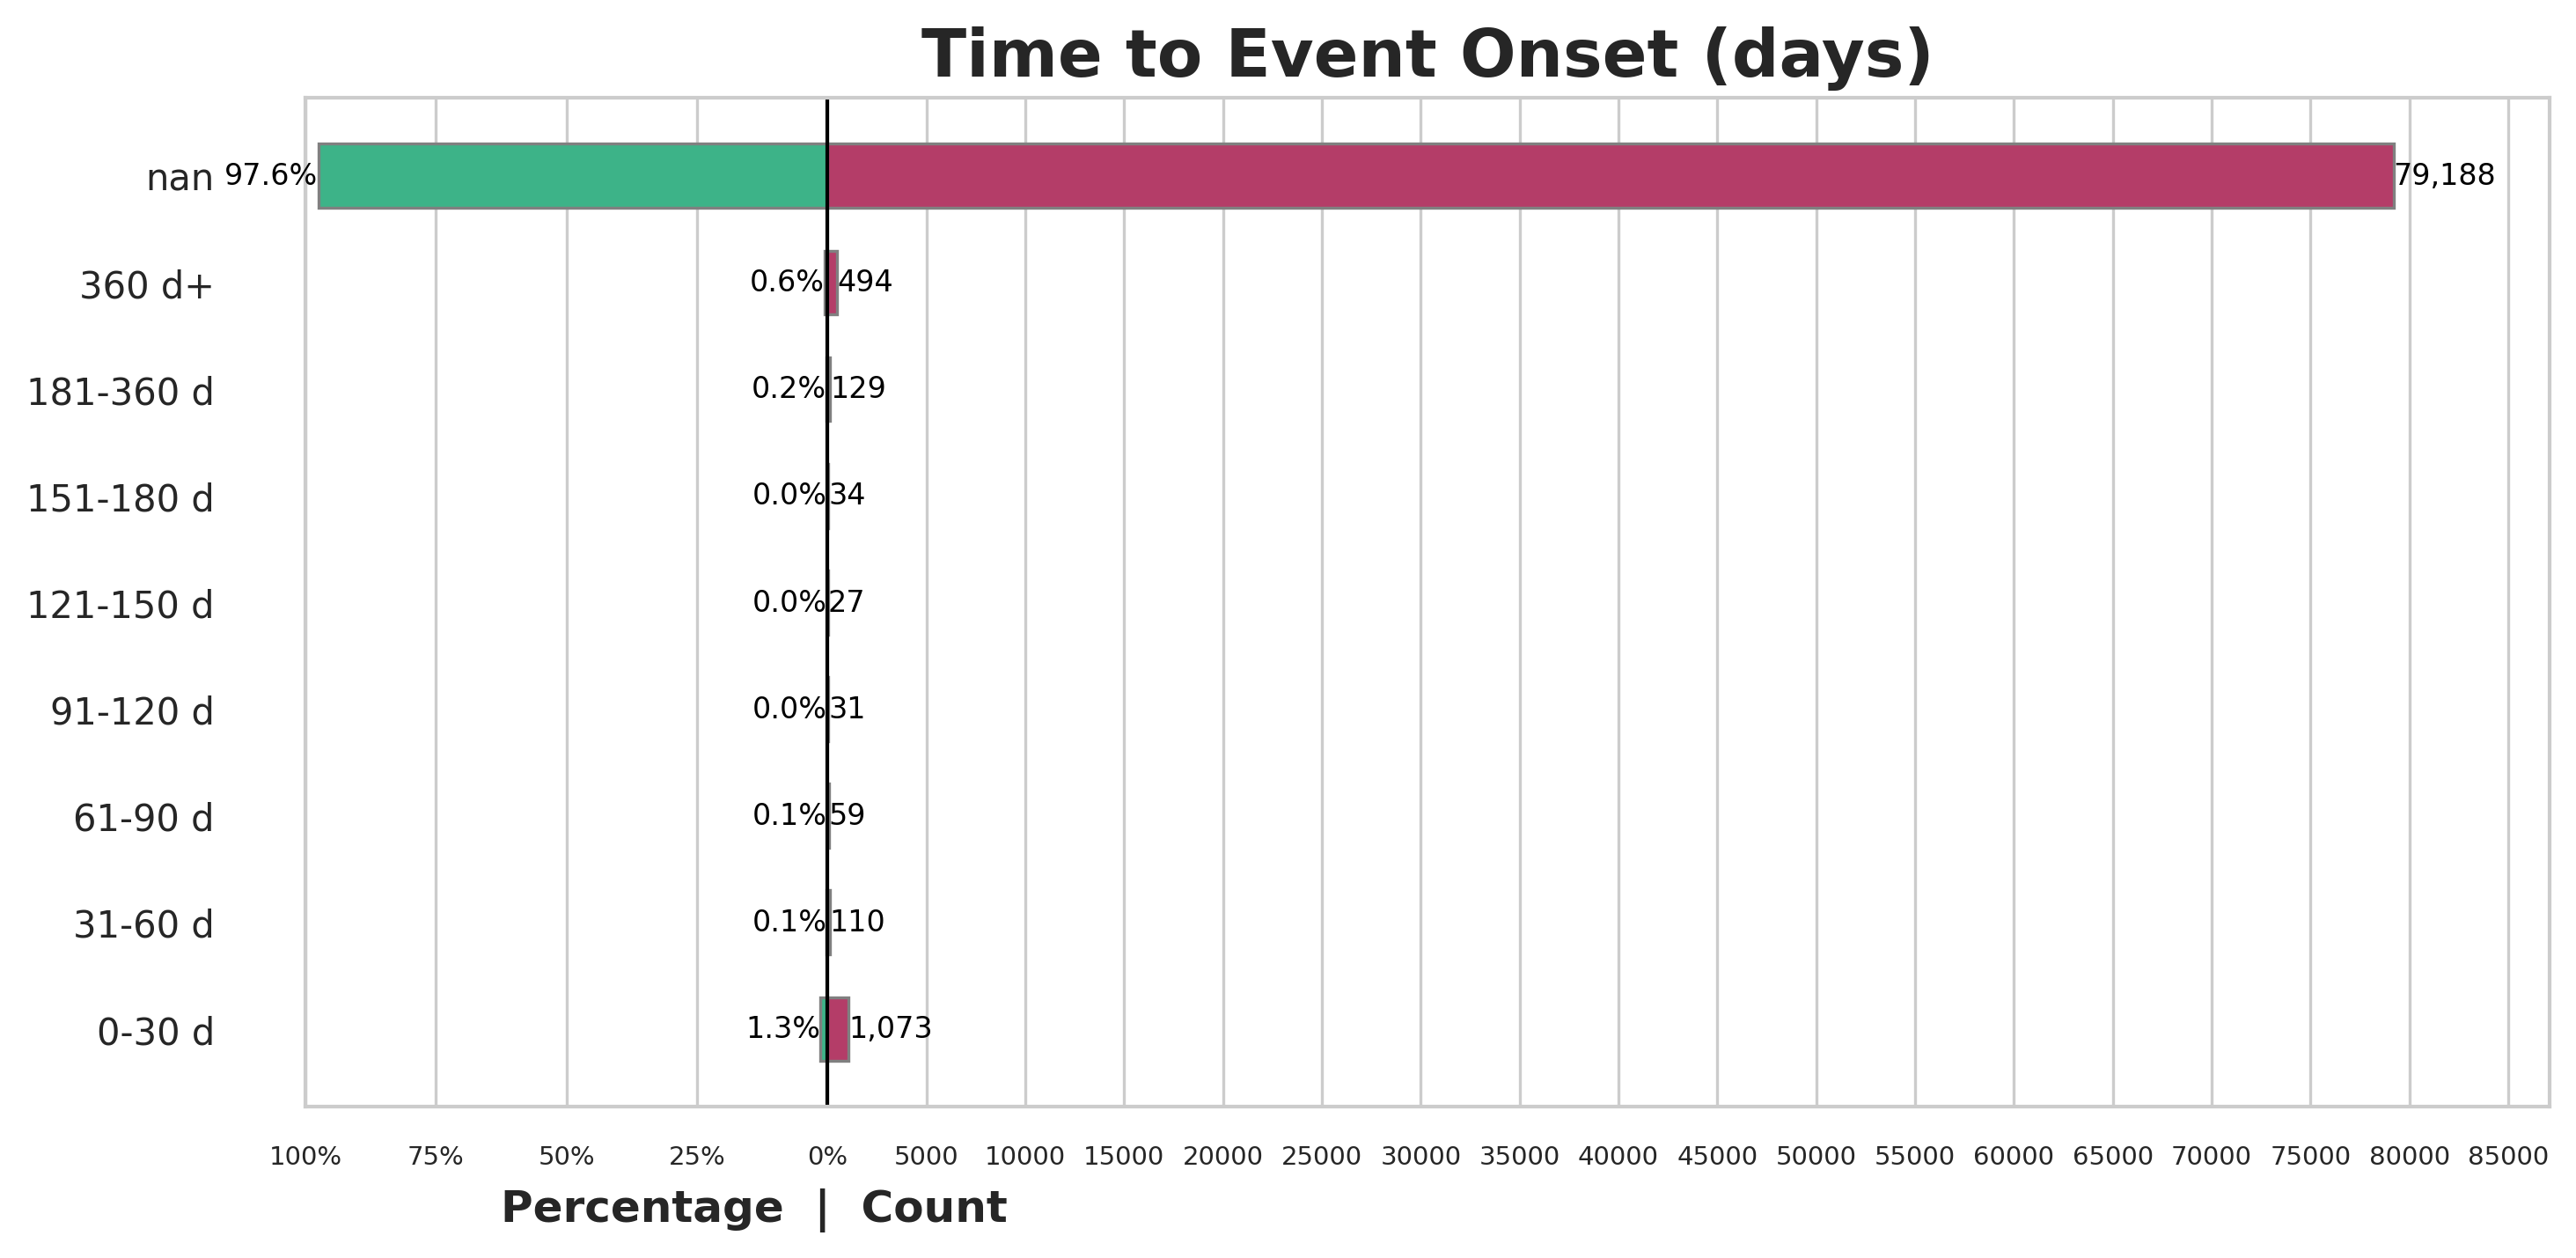

In [16]:
LR_PROPORTION = 3

def process_value(x):
    if pd.isna(x):
        return float('inf')
    if "360 d+" in x:
        return float('inf') - 1

    try:
        return float(x.split('-')[0].strip())
    except ValueError:
        return float('inf')


def plot_duration_days_frequency(data_path, output_path):
    bsc_info_event_onset_days = pd.read_excel(data_path)

    data = bsc_info_event_onset_days[bsc_info_event_onset_days['dur_group']  != 'Missing' ].copy()


    total = data['count'].sum()
    data['percentage'] = data['count'] / total * 100


    data['sort_key'] = data['dur_group'].apply(process_value)
    data = data.sort_values(by='sort_key', ascending=True).drop(columns=['sort_key'])


    fig, ax = plt.subplots(figsize=(10,5))


    y = np.arange(len(data))


    max_count = data['count'].max()

    left_max_ax = max_count / LR_PROPORTION
    left_max_ax_percent = left_max_ax / 100

    data['percentage'] = data['percentage'] * left_max_ax_percent
    max_percentage = data['percentage'].max()

    left_limit_original = -max_percentage * 2
    right_limit_original = max_count * 1.1
    total_width_original = right_limit_original - left_limit_original

    new_axis_original = left_limit_original + (total_width_original / 3)
    new_axis = new_axis_original + 20

    # left_limit_new = new_axis - 100
    left_limit_new = new_axis - left_max_ax
    right_limit_new = new_axis + max_count * 1.1
    ax.set_xlim(left_limit_new, right_limit_new)


    ax.barh(y, -data['percentage'], height=0.6, left=new_axis,
            color='#3DB388', edgecolor='grey')

    ax.barh(y, data['count'], height=0.6, left=new_axis,
            color='#B43D68', edgecolor='grey')

    ax.axvline(x=new_axis, color='black', linestyle='-', linewidth=1)


    ax.set_yticks(y)
    ax.set_yticklabels(data['dur_group'])
    ax.tick_params(axis='y', pad=20)

    percentage_values = [25, 50, 75, 100]
    percentage_ticks = [new_axis - (val / 100) * left_max_ax for val in percentage_values]  # 计算对应的刻度位置

    s = str(max_count * 2)
    length = len(s)
    highest = int(s[0])
    max_integer = highest * (10 ** (length - 1))
    count_ticks = np.arange(0, right_limit_new-new_axis, max_integer / 20)
    count_positions = new_axis + count_ticks

    all_ticks = np.concatenate([percentage_ticks, count_positions])
    ax.set_xticks(all_ticks)

    ax.set_xticklabels([
        f"{int(((tick - new_axis) / -left_max_ax) * 100)}%" if tick <= new_axis
        else f"{int(tick - new_axis)}"
        for tick in all_ticks
    ])


    for i, (perc, count) in enumerate(zip(data['percentage'], data['count'])):
        ax.text(new_axis - perc, i, f'{perc / left_max_ax_percent:.1f}%',
                ha='right', va='center', color='black', fontsize=8)
        ax.text(new_axis + count, i, f'{count:,}',
                ha='left', va='center', color='black', fontsize=8)

    fig.subplots_adjust(top=0.88)
    ax.set_title('Time to Event Onset (days)', size = 18, fontweight='bold')
    ax.set_xlabel('Percentage  |  Count', size=12, labelpad=6, fontweight='bold')
    # nudge in axes‐fraction coordinates (0 is left, 1 is right)
    ax.xaxis.set_label_coords(0.2, -0.08)
    # ax.set_ylabel('Duration Groups')
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=7)

    ax.grid(False, which='major', axis='y')

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    plt.savefig(output_path)
    plt.tight_layout()
    plt.show()

plot_duration_days_frequency(f"{base_path}/MINING_REPORT/basic_info_duration.xlsx",
                        f"{base_path}/VISUALIZATIONS/[3001]DURATION_DAYS_FREQUENCY.png")

# **[2010] DRUG_GOAL2 - AE Accumulation**

In [17]:
def plot_ae_accumulation(data_path, output_path):
    df = pd.read_csv(data_path)

    df = df[df['dur_days'].notna()]

    dur_days = df['dur_days'].sort_values()
    n = len(dur_days)
    cumulative_incidence = np.arange(1, n + 1) / n

    mask = dur_days <= 7250
    dur_days = dur_days[mask]
    cumulative_incidence = cumulative_incidence[mask]

    unique_dur_days, unique_indices = np.unique(dur_days, return_index=True)
    unique_cumulative = cumulative_incidence[unique_indices]

    spline = UnivariateSpline(unique_dur_days, unique_cumulative, k=3, s=0.1)

    x_smooth = np.linspace(unique_dur_days.min(), unique_dur_days.max(), 500)
    y_smooth = spline(x_smooth)

    y_smooth = np.maximum.accumulate(y_smooth)


    y_smooth = np.clip(y_smooth, None, 0.992)
    plt.figure(figsize=(8, 4.5), dpi=300)
    plt.plot(x_smooth, y_smooth, color='red', linewidth=3, label='Cumulative Counts of Adverse Event ')
    plt.xlabel('Cumulative (days)', fontsize=12, fontweight='bold')
    plt.ylabel('Cumulative Adverse Event(%)', fontsize=12, fontweight='bold')
    plt.xlim(-500, 8500)
    plt.xticks(np.arange(0, 8001, 2000), fontsize=12)
    plt.yticks(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Cumulative Adverse Event Accumulation', fontsize=16, fontweight='bold')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_ae_accumulation(f"{base_path}/RAW_DATA/DRUG_GOAL2.csv",
                    f"{base_path}/VISUALIZATIONS/[2010]AE_ACCUMULATION.png")

# **[2011] OUTC_GOAL - Outcome Code Histogram**

<ipython-input-18-0792b4a03083>:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['label'], rotation=25, ha='right')


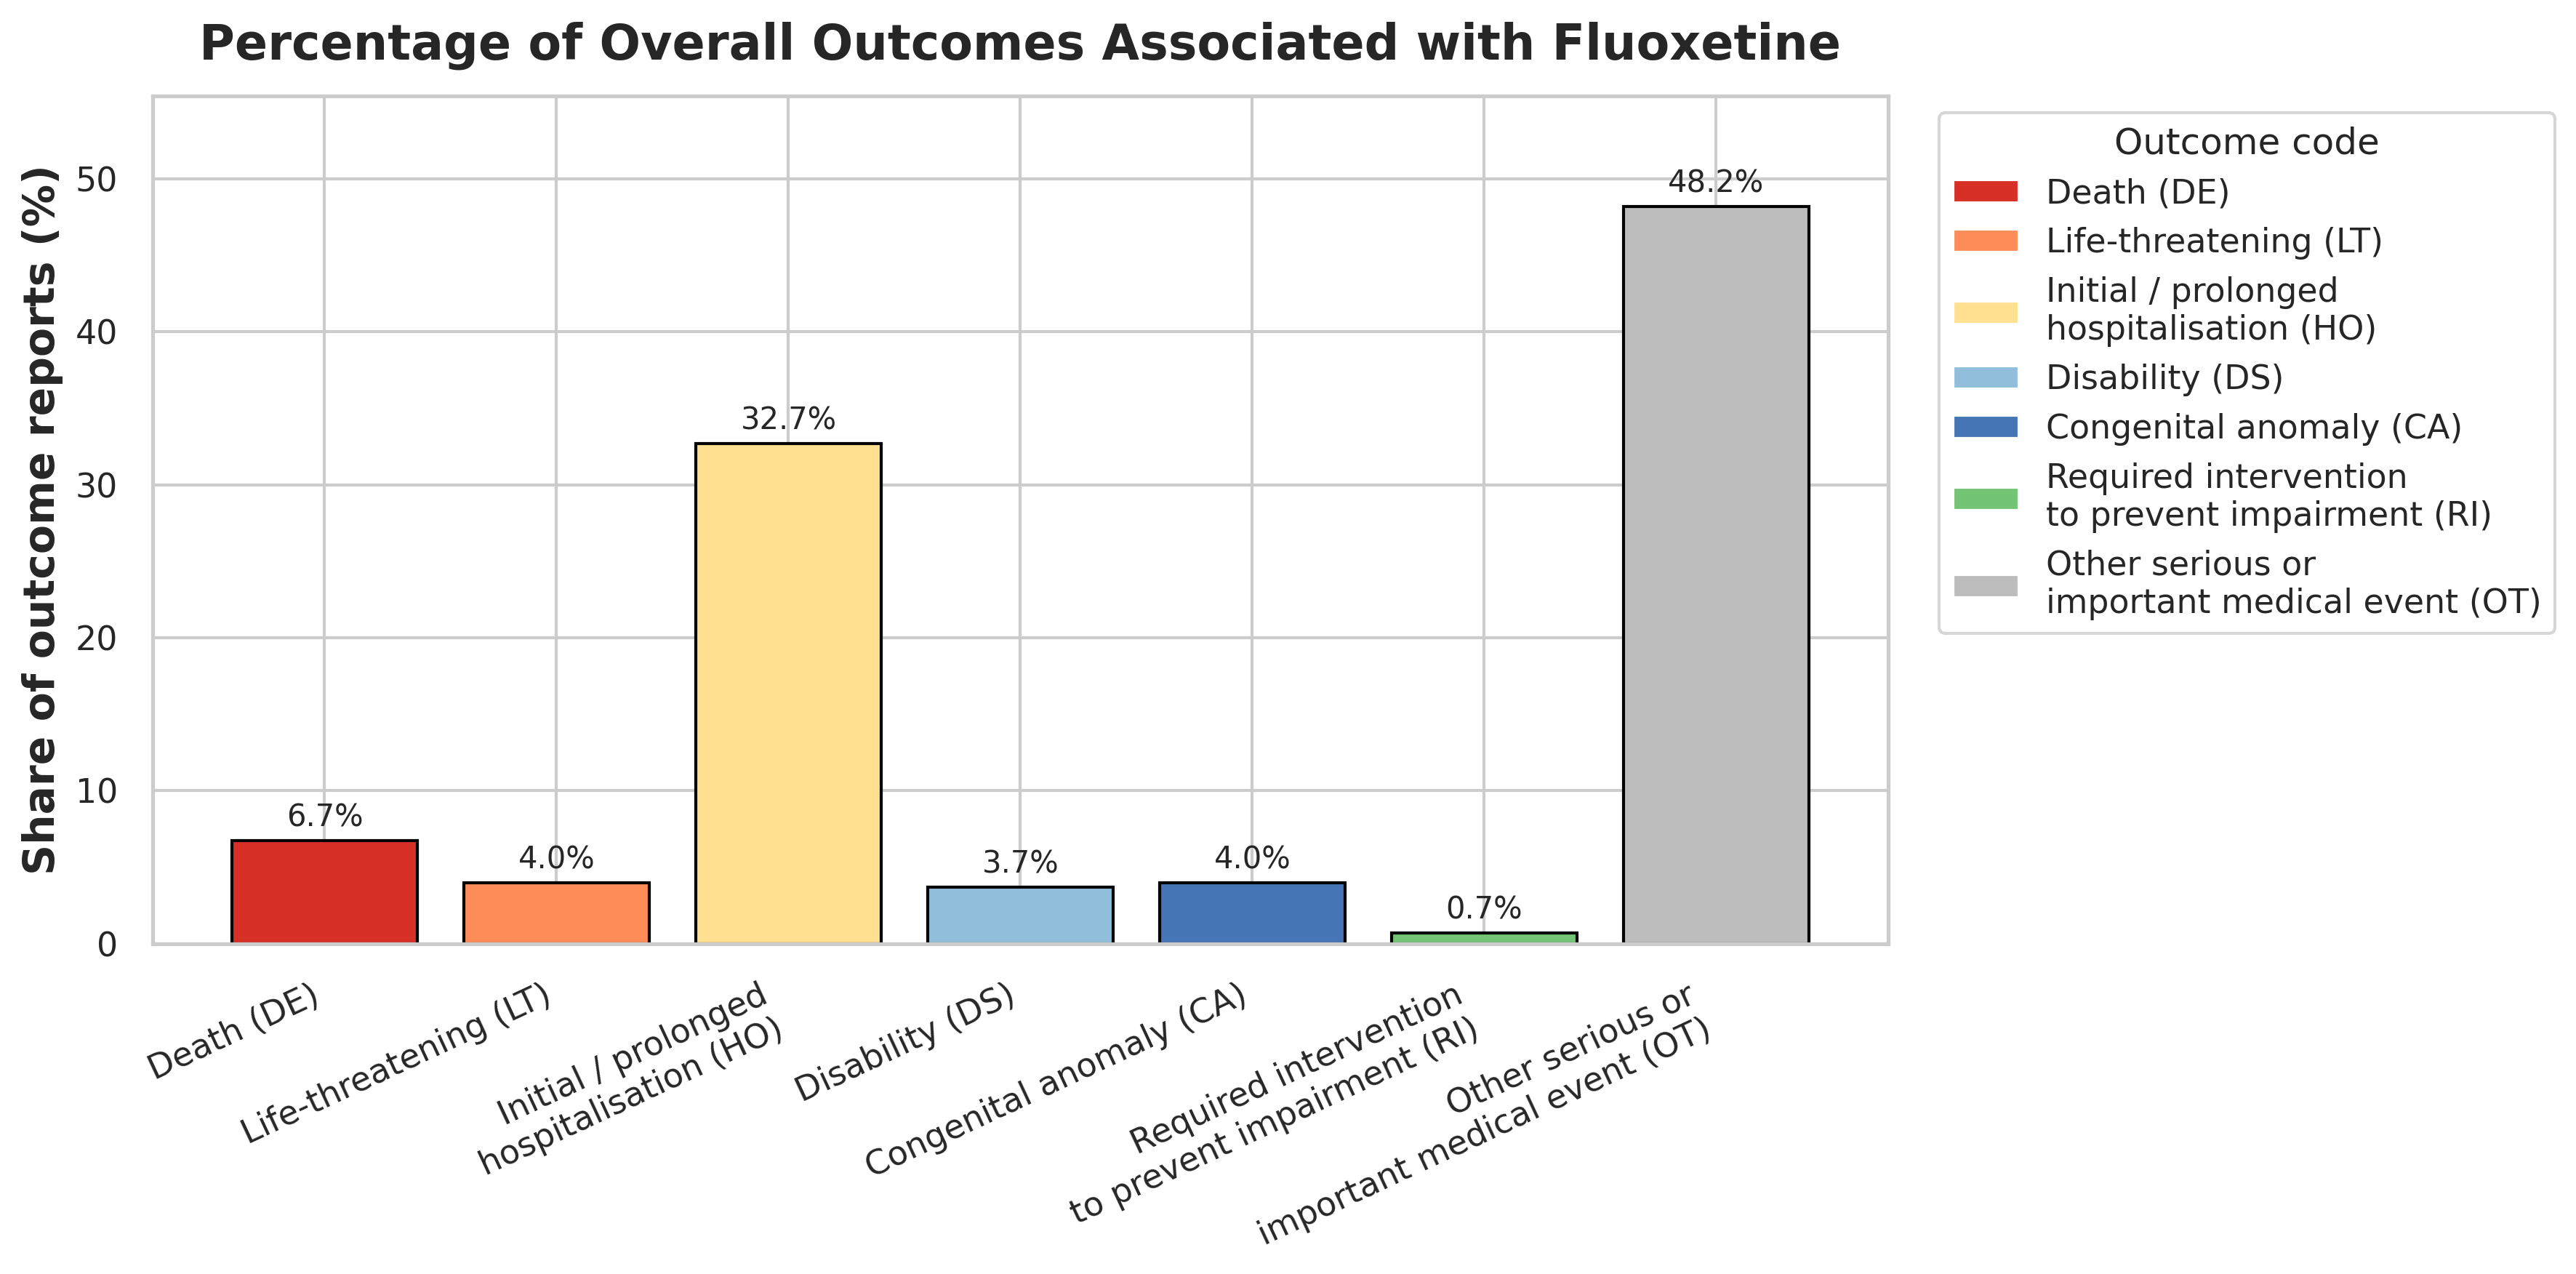

In [18]:
def plot_outcome_histogram(data_path, output_path):

    df = pd.read_excel(data_path, dtype={'outc_cod': str, 'count': int})

    order = ['DE', 'LT', 'HO', 'DS', 'CA', 'RI', 'OT']
    code2label = {
        'DE': 'Death (DE)',
        'LT': 'Life‑threatening (LT)',
        'HO': 'Initial / prolonged\nhospitalisation (HO)',
        'DS': 'Disability (DS)',
        'CA': 'Congenital anomaly (CA)',
        'RI': 'Required intervention\nto prevent impairment (RI)',
        'OT': 'Other serious or\nimportant medical event (OT)'}
    palette = ['#d73027', '#fc8d59', '#fee090',
               '#91bfdb', '#4575b4', '#74c476', '#bdbdbd']

    # keep only the seven recognised codes and order them
    df = (df[df.outc_cod.isin(order)]
            .set_index('outc_cod')
            .reindex(order)
            .reset_index())

    df['percentage'] = df['count'] / df['count'].sum() * 100
    df['label'] = df['outc_cod'].map(code2label)


    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(df['label'],
                  df['percentage'],
                  color=palette,
                  edgecolor='black')

    # axis cosmetics
    ax.set_ylabel('Share of outcome reports (%)', fontsize=14, fontweight='bold')
    ax.set_title(f'Percentage of Overall Outcomes Associated with Fluoxetine',
                 fontsize=16, weight='bold', pad=12)
    ax.set_ylim(0, df['percentage'].max()*1.15)
    ax.set_xticklabels(df['label'], rotation=25, ha='right')

    # numerical labels on top of each bar
    for bar, pct in zip(bars, df['percentage']):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.5,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=10)

    # legend that matches bar colours
    legend_handles = [Patch(facecolor=palette[i], label=code2label[order[i]])
                      for i in range(len(order))]
    ax.legend(handles=legend_handles, title='Outcome code',
              bbox_to_anchor=(1.02, 1), loc='upper left')

    fig.tight_layout()
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


plot_outcome_histogram(f"{base_path}/MINING_REPORT/basic_info_outcome.xlsx",
                       f"{base_path}/VISUALIZATIONS/[2011]OUTCOME.png")


# **[3003] DEMO_GOAL - Age & Sex**

In [19]:
def plot_age_sex(data_path, output_path):
    try:
        df = pd.read_excel(data_path, index_col=0, engine='openpyxl')
    except Exception:
        df = pd.read_csv(data_path, index_col=0)


    age_order = ['0-2', '2-10', '10-18', '18-30', '30-45', '45-60', '60-80', '80+', 'Missing']
    df_plot = (df[['F','M', 'Missing']].reindex(age_order))
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    colors = {'F': '#4C72B0', 'M': '#DD8452', 'Missing': '#77AC30'}

    bottom = None
    for sex in ['F', 'M', 'Missing']:
        vals = df_plot[sex].values
        ax.bar(
            x=range(len(df_plot.index)),
            height=vals,
            bottom=bottom,
            width=0.6,
            color=colors[sex],
            label=sex,
            edgecolor='white',
            linewidth=0.5
        )
        bottom = vals if bottom is None else bottom + vals

    ax.set_xticks(range(len(df_plot.index)))
    ax.set_xticklabels(df_plot.index, fontsize=10)
    ax.set_xlabel('Age Group', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Count', fontsize=12, fontweight = 'bold', labelpad=10)
    ax.tick_params(axis='y', which='major', labelsize=9)

    ax.legend(
        title='Sex',
        frameon=True,
        edgecolor='0.8',
        title_fontsize=10,
        fontsize=9,
        loc='upper left'
    )

    totals = df_plot.sum(axis=1)
    for i, total in enumerate(totals):
        ax.text(
            x=i,
            y=total + totals.max() * 0.02,
            s=str(int(total)),
            ha='center',
            va='bottom',
            fontsize=8,
            color='0.3'
        )
    ax.set_ylim(0, df_plot[['F', 'M']].sum(axis=1).max() * 1.5)

    plt.title('Gender Distribution Across Age Groups', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

plot_age_sex(f"{base_path}/MINING_REPORT/basic_info_age_sex.xlsx",
             f"{base_path}/VISUALIZATIONS/[3003]AGE_SEX.png")